# VaR and ES Case Study

**Description:** Let the dimension $d = 40$, we suppose the input vector $X \sim \mathcal{N}(0,\mathbf{I}_d)$ and $Y \mid X \sim \mathcal{N}\left(P_{1}(X),\left(P_{2}(X)\right)^{2}\right)$ where $P_1$ and $P_2$ are multivariate polynomials of degree 2. For every $x = (x_1, \dots, x_d) \in \mathrm{R}^d$, and coefficients $\lambda$ and $\mu$ following a uniform distribution between $0$ and $1$,
\begin{align*}
    P_1(x) &= \sum_{i=1}^{d} \lambda_{i} x_{i} + \sum_{1 \leq i, j \leq d} \lambda_{i, j} x_{i} x_{j} \\
    P_{2}(x)&= \sum_{i=1}^{d} \mu_{i} x_{i}+\sum_{1 \leq i, j \leq d} \mu_{i, j} x_{i} x_{j}
\end{align*}
Each of training and test sets includes $50,000$ samples drawn from the model setting. In this case study, the data does not need to be scaled or normalized.

**Benchmarking:** As the conditional probability distribution of $Y$ given $X$ is known, that allows us to compute the true conditional VaR and ES of $Y$ given $X$ at confidence level $(1-\epsilon) \;(=97.5\%)$. Denoting by $\Phi$ the cumulative distribution function of the standard normal distribution and by $\varphi$ its density, we have:
\begin{align*}
    \mathrm{VaR}(Y\mid X) &= P_1(X) - P_2(X)\Phi^{-1}(\epsilon) \\
    \mathrm{ES}(Y \mid X) &= P_1(X) + \frac{1}{\epsilon}P_2(X) \varphi\left(\Phi^{-1}(\epsilon)\right)
\end{align*}
We then benchmark training models by NRMSE between the prediction and the true metrics. 

Note that the true metrics will be neither used for training nor for tuning models. The training process is implemented by using simulated input and output via functional methods: two-step and joint approach.

**Outline:**
* Model setup and hyper parameter spaces are specified in Section 0 
* We code classes and functions in Section 1 to 3
* Hyper parameter optimisations for VaR (quantile) regression are implemented in Section 4. That gives us some references. We then carefully examine each model in section 5. Note that the hyper parameter tuning for standard NN takes long time and the scores are not largely different, so one can manually try out some combinaison in Section 5.
* Section 5 implements two-step approach
* Section 6 trains joint loss
* Section 7 benchmarks models

---

Before starting, we need to install ```cuml``` by the following cell. This is a new GPU-accelerated machine learning platform developed by NVIDIA team, which does the linear regression (i.e. matrix inversion) much faster than Scikit-learn and more stably than PyTorch.

**Attention:** The installation may take several minutes (~ 10m).



In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

In [ ]:
import cuml

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import time
import sys, gc
import seaborn as sns
import random
from itertools import chain
from tqdm.notebook import tqdm
import math
import scipy as si
from scipy.stats import norm

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

import pandas as pd
import tensorflow as tf
import tensorflow.compat.v1 as tf1
from sklearn.preprocessing import PolynomialFeatures
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import torch 
from torch import matmul
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import torch.distributions as tdist

#from kmeans_pytorch import kmeans

print('GPU available: ',torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU available:  True


#0 Model parameters and Hyper parameters

We define model parameters and hyper parameter spaces which are used for tuning models.

In [ ]:
### Model parameters
dim_X = 40

N_sim = 50000

eps = 0.025

### Hyper parameters 
Kfold = 3
max_epochs = 300

learning_rate = hp.choice('learning_rate',[0.001,0.01,0.1,0.5,1])
batchsize = hp.choice('batchsize',[1000, 5000, N_sim])
unit_num = hp.choice('unit_num',[40,100,200,400])
hlayer_num = hp.choice('layer_num',[1,2])
regularization_weight = hp.choice('regularization_weight',[0,0.1,0.5,1])
activation = hp.choice('activation', [F.relu, F.sigmoid, F.softplus, F.elu])

space_NN = {
    'learning_rate': learning_rate,
    'batch_size': batchsize,
    'unit_num': unit_num,
    'hlayer_num': hlayer_num,
    'regularization_weight': regularization_weight,
    'activation': activation
}

space_ELM = {
    'unit_num': hp.choice('unit_num',[100,200,400,600]),
    'projection': hp.choice('projection', ['Gauss', 'Rademacher', 'Achlioptas']),
    'regularization_weight': regularization_weight,
    'activation': activation
}

space_RBF = {
    'unit_num': hp.choice('unit_num',[40,100,200,20]),
    'regularization_weight': regularization_weight,
    'activation': hp.choice('activation', ['Gaussian', 'Multiquadric', 'Inverse quadratic', 'Thin plate spline']),
    'shape_para': hp.choice('shape_para',[.1,0.5,1,2,5,10])
}


# 1 Data simulator

In [ ]:
class var_es_generator:
    """ 
    Data generator for VaR and ES Case study

    var_es_generator simulates a matrix of input X, an output vector Y
    and true conditional VaR and ES for benchmark.  

    Parameters
    ----------
    dim_X : int, default= Model parameters
        Dimension of input features.
    eps : float, default= Model parameters
        1 - eps is the involved confidence level. 0 < eps < 1.
    lambda_0 : float, default= 0
        Intercept in the polynomial function of conditional mean.
    mu_0 : float, default= 0
        Intercept in the polynomial function of conditional standard deviation.    
    lambda_rs : int, default= None
        Determines random number generation for lambda coefficients.    
    mu_rs : int, default= None
        Determines random number generation for mu coefficients.     
    Attributes
    ----------
    dim_X : int
    eps : float
    lambda_vector : array
        Vector of lambda coefficient drawn independently from U[0,1]
    mu_vector : array
        Vector of lambda coefficient drawn independently from U[0,1]
    Notes
    ----------
    Data is sumulated on CPU.    
    """
    def __init__(self, dim_X = dim_X, eps = eps, lambda_0 = 0., mu_0 = 0.,
                 lambda_rs = None, mu_rs = None):
        self.dim_X = dim_X
        self.eps = eps
        
        self.lambda_vector = np.append(lambda_0, np.random.RandomState(lambda_rs).uniform(0,1, int(dim_X + dim_X*(dim_X+1)/2) ))
        self.mu_vector = np.append(mu_0, np.random.RandomState(mu_rs).uniform(0,1, int(dim_X + dim_X*(dim_X+1)/2) ))
    
    def mean_X(self):
        """
        Generate mean vector of X

        Returns
        -------
        Mean vector 
        """
        return np.zeros(self.dim_X)
    
    def var_X(self, correlation = False):
        """
        Generate covariance matrix of X

        Parameters
        ----------
        correlation : bool, default= False
            If True, return a full symmetric (dim_X, dim_X) covariance matrix,
            else return an identity matrix.
        Returns
        -------
        Covariance matrix 
        """
        
        if correlation == False:
            return np.identity(self.dim_X)
        else:
            A = np.random.randn(self.dim_X,self.dim_X)
            A = np.matmul(A.T,A)
            A /= A.max()
            np.fill_diagonal(A,1)
            return A

    def poly_function(self, X, coefficient_vector): 
        """
        Compute a multivariate polynomial function of degree 2 from a input and
        coefficient vector.

        Parameters
        ----------
        X : array
            A input vector.
        coefficient_vector: array
            A coefficient vector.
        Returns
        -------
        A real-value of polynomial of degree 2.
        """
        poly = PolynomialFeatures(2)
        return np.sum(poly.fit_transform(X) * coefficient_vector, axis = 1)
    
    def simulate(self, N_sim = N_sim) :

        """
        Simulate data and wrap to torch.Tensor.
        Parameters
        ----------
        N_sim : int, default= Model parameters
            Number of observations to simulate.
        Returns
        -------
        X : torch.Tensor, shape (N_sim, dim_X)
            Matrix of input
        Y : torch.Tensor, shape (N_sim, 1) 
            Vector of output
        true_var : torch.Tensor, shape (N_sim, 1)
            Vector of true conditional VaR for benchmark. 
        true_es : torch.Tensor, shape (N_sim, 1)
            Vector of true conditional ES for benchmark. 
        mean_Y : torch.Tensor, shape (N_sim, 1)
            Vector of true mean of Y. 
        std_Y : torch.Tensor, shape (N_sim, 1)
            Vector of true standard deviation of Y. 
        """                
        X = np.random.multivariate_normal(self.mean_X(), self.var_X(), N_sim)

        mean_Y = self.poly_function(X, self.lambda_vector)
        std_Y = self.poly_function(X, self.mu_vector)
        std_Y = np.sqrt(std_Y**2)
        
        Y = np.random.normal(mean_Y, std_Y)

        true_VaR = mean_Y - std_Y*norm.ppf(self.eps)
        true_ES = mean_Y + 1/self.eps * std_Y * norm.pdf(norm.ppf(self.eps)) 

        return (torch.from_numpy(X.reshape(N_sim, self.dim_X)).type(torch.FloatTensor), 
                torch.from_numpy(Y.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(true_VaR.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(true_ES.reshape(-1,1)).type(torch.FloatTensor),
                mean_Y,
                std_Y)

Let simulate data

In [ ]:
Data_Generator = var_es_generator()

X_train, Y_train, true_VaR_train, true_ES_train, _,_ = Data_Generator.simulate()
X_test, Y_test, true_VaR_test, true_ES_test, _,_ = Data_Generator.simulate()

We test our simulation by some density plots.

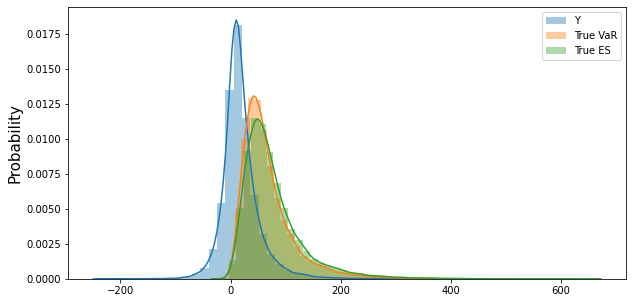

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(Y_train.data, label='Y')
sns.distplot(true_VaR_train.data, label='True VaR')
sns.distplot(true_ES_train.data, label='True ES')
plt.title("", fontsize=12)
plt.xlabel("")
plt.ylabel("Probability", fontsize=15)
plt.legend()

It seems good. We create a function which allows us to quickly redraw data.

In [ ]:
sys_variables = sys.modules[__name__]

def data_simulator(nb_path = N_sim):
    try:
        del sys_variables.X_train, sys_variables.Y_train, sys_variables.true_VaR_train, sys_variables.true_ES_train
        del sys_variables.X_test, sys_variables.Y_test, sys_variables.true_VaR_test, sys_variables.true_ES_test
        torch.cuda.empty_cache()
    except:
        pass
    
    X_train, Y_train, true_VaR_train, true_ES_train, mean_Y_train, std_Y_train = Data_Generator.simulate(nb_path)
    X_test, Y_test, true_VaR_test, true_ES_test, mean_Y_test, std_Y_test = Data_Generator.simulate(nb_path)

    sys_variables.X_train = X_train.to(device)
    sys_variables.Y_train = Y_train.to(device)
    sys_variables.true_VaR_train = true_VaR_train.to(device)
    sys_variables.true_ES_train = true_ES_train.to(device)

    sys_variables.X_test = X_test.to(device)
    sys_variables.Y_test = Y_test.to(device)
    sys_variables.true_VaR_test = true_VaR_test.to(device)
    sys_variables.true_ES_test = true_ES_test.to(device)


In [ ]:
data_simulator()

We then define metric  and density plot functions.

In [ ]:
def NRMSE(pred, true):
    """
    Normalized Root-Mean-Square Error
    
    It is Root-Mean-Square Error normalized by the standard error of true target.

    Parameters
    ----------
    pred : torch.Tensor
    true : torch.Tensor
    Returns
    -------
    NRMSE. 
    """
    pred = pred.cpu().reshape(true.shape)
    true = true.cpu()
    return float(torch.sqrt(torch.mean((pred - true)**2))/ torch.std(true))

def RMSE(pred, true):
    """
    Root-Mean-Square Error
    
    It is Root-Mean-Square Error between the prediction and true target.

    Parameters
    ----------
    pred : torch.Tensor
    true : torch.Tensor
    Returns
    -------
    RMSE. 
    """
    pred = pred.cpu().reshape(true.shape)
    true = true.cpu()
    return float(torch.sqrt(torch.mean((pred - true)**2)))

def qloss(pred, y):
    """
    Quantile loss
    
    This function computes quantile (pinball) loss.

    Parameters
    ----------
    pred : torch.Tensor
    y : torch.Tensor
    Returns
    -------
    NRMSE. 
    """
    u = y.reshape(pred.shape).cpu() - pred.cpu()
    return float(torch.mean((u)*(1- eps - (u<0)*1)))

def q_proba(pred, y):
    """
    Quantile probability
    
    This function computes probability that the target exceed the prediction.

    Parameters
    ----------
    pred : torch.Tensor
    y : torch.Tensor
    Returns
    -------
    NRMSE. 
    """
    pred = pred.cpu().reshape(y.shape)
    y = y.cpu()
    return float(sum(y >pred))/len(y)

def huber_loss(pred, y, tau, eps = eps):
    """
    Huber loss
    
    This function computes Huber loss which allows to train quantile model.

    Parameters
    ----------
    pred : torch.Tensor
    y : torch.Tensor
    tau : float
        Huber switching threshold.
    eps : float, default = Model parameters
    Returns
    -------
    Huber loss. 
    """
    zero_vector = torch.zeros_like(y)
    u = y - pred
    hu = u**2/(2*tau)*(torch.abs(u)<=tau) + (torch.abs(u) - tau/2)*(torch.abs(u)>tau)
    loss_var = torch.mean((1-eps)*hu*(u>=zero_vector) + eps*hu*(u<zero_vector))
    return loss_var

def plot_function(var_train_pre, var_train_true, es_train_pre, es_train_true,
                  var_test_pre, var_test_true, es_test_pre, es_test_true):
    """
    Plot function
    
    This function print all comparison metrics and density plot of predicted and 
    true VaR and ES.

    Parameters
    ----------
    var_train_pre : torch.Tensor 
    var_train_true : torch.Tensor
    es_train_pre : torch.Tensor
    es_train_true : torch.Tensor
    var_test_pre : torch.Tensor
    var_test_true : torch.Tensor
    es_test_pre : torch.Tensor
    es_test_true : torch.Tensor
    Returns
    -------
    Print and plot results. 
    """

    [var_train_pre, var_train_true, es_train_pre, es_train_true,
     var_test_pre, var_test_true, es_test_pre, es_test_true]= \
     [var.cpu() for var in [var_train_pre, var_train_true, es_train_pre, es_train_true,
                            var_test_pre, var_test_true, es_test_pre, es_test_true]]

    plt.figure(figsize=(14,7))
    plt.subplot(221)
    g = sns.distplot(var_test_pre.cpu().data, label='predicted VaR')
    g = sns.distplot(var_test_true.data, label='True VaR')
    g = plt.title("out-of-sample VaR distributions", fontsize=12)
    g = plt.xlabel("")
    g = plt.ylabel("Probability", fontsize=10)
    g = plt.legend()

    plt.subplot(222)
    g = sns.distplot(es_test_pre.data, label='predicted ES')
    g = sns.distplot(es_test_true.data, label='True ES')
    g = plt.title("out-of-sample ES distributions", fontsize=12)
    g = plt.xlabel("")
    g = plt.ylabel("Probability", fontsize=10)
    g = plt.legend()

    plt.figure(figsize=(12,10))
    plt.subplot(321)
    d = pd.DataFrame(np.concatenate([(var_train_pre - var_train_true).detach().numpy(),
                                     (var_test_pre - var_test_true).detach().numpy()]), columns = ['error'])
    d['sample'] = ['train']*len(var_train_pre) + ['test']*len(var_train_pre)
    g = sns.violinplot(x = 'sample', y = 'error', data=d, palette="Set1")
    g = plt.title("Violinplot VaR error", fontsize=12)

    plt.subplot(322)
    d = pd.DataFrame(np.concatenate([(es_train_pre - es_train_true).detach().numpy(),
                                     (es_test_pre - es_test_true).detach().numpy()]), columns = ['error'])
    d['sample'] = ['train']*len(var_train_pre) + ['test']*len(var_train_pre)
    g = sns.violinplot(x = 'sample', y = 'error', data=d, palette="Set1")
    g = plt.title("Violinplot ES error", fontsize=12)

    print('NRMSE in-sample VaR: ',NRMSE(var_train_pre.data, var_train_true.data))
    
    print('NRMSE out-sample VaR: ',NRMSE(var_test_pre.data, var_test_true.data))
    print('NRMSE in-sample ES: ',NRMSE(es_train_pre.data, es_train_true.data))
    print('NRMSE out-sample ES: ',NRMSE(es_test_pre.data, es_test_true.data))

    print('RMSE in-sample VaR: ',RMSE(var_train_pre.data, var_train_true.data))
    print('RMSE out-sample VaR: ',RMSE(var_test_pre.data, var_test_true.data))

    print('Quantile loss in-sample: ', qloss(var_train_pre.data, Y_train))
    print('Quantile loss out-sample: ', qloss(var_test_pre.data, Y_test))

    print('Quantile proba in-sample: ', q_proba(var_train_pre.data, Y_train))
    print('Quantile proba out-sample: ', q_proba(var_test_pre.data, Y_test))

#2 Randomized layers

Two design for randomized layers: Random projection (ELM) and RBF function

In [ ]:
class Rademacher_dist:
    """ 
    Rademacher distribution

    Rademacher_dist is a generator of Rademacher distribution taking values 
    +1 and −1 with probability 1/2 for each. Rademacher_dist serves to create 
    random projection matrix.
    """
    def sample(dim):
        """
        Simulate data drawn from Rademacher distribution.

        Parameters
        ----------
        dim : list
            Shape of simulated data.
        Returns
        -------
        Generated data whose the shape = dim.
        """
        return 2*tdist.bernoulli.Bernoulli(0.5).sample(dim)-1
        
class Achlioptas_dist:
    """ 
    Achlioptas distribution

    Achlioptas_dist is a generator of Rademacher distribution taking values 
    +√3, 0 and −√3 with probability 1/6, 2/3, 1/6 respectively. Rademacher_dist 
    serves to create random projection matrix.  
    """
    def sample(dim):
        """
        Simulate data drawn from Achlioptas distribution.
        
        Parameters
        ----------
        dim : list
            Shape of simulated data.
        Returns
        -------
        Generated data whose the shape = dim.
        """
        return (tdist.categorical.Categorical(probs=torch.tensor([1/6,2/3,1/6])).sample(dim) -1)*np.sqrt(3)

class Randomprojection:
    """ 
    Random projection mapping

    Randomprojection maps the input data into a new dimentional space, a bias 
    term can be added to transformed data, and then an activation function can 
    be applied. Randomprojection can transform the data several times but it is 
    not necessary.

    Parameters
    ----------
    Layers : list, default= [10,100]
        The first element of this list is the dimension of input, the second 
        element is the dimension of new space. If the length of list d is more
        than two, this means the transformation is applied d-1 times into the 
        corresponding dimension of new spaces. 
    bias : bool, default= True
        Whether to apply the intercept for the transformation.
    activation : function, default= F.relu
        Activation function.
    projection : string, default = 'Gauss'
        The distribution of Random projection: 'Gauss' for Gaussian distribution,
        'Rademacher' for Rademacher distribution and 'Achlioptas' for Achlioptas 
        distribution.        
    random_state : int, default= None
        Determines random number generation for random projection matrix.     
    Attributes
    ----------
    dist : distribution
        Random projection distribution.
    W : list
        List of weights (cf. Random projection matricies). The length of this
        list is equal to the one of Layers minus one.
    b : list
        List of biases. It is empty if bias = False
    activation : function
        Activation function.
    bias : bool
        Whether to apply the intercept for the transformation.
    """
    def __init__(self, Layers = [10, 100], bias = True, activation = F.relu, projection = 'Gauss', random_state = None):
        if projection == 'Gauss':
            dist = tdist.normal.Normal(0., 1.)
        elif projection == 'Rademacher':
            dist = Rademacher_dist
        elif projection == 'Achlioptas':
            dist = Achlioptas_dist

        self.W, self.b =[], []
        if random_state == None:
            for input_size, output_size in zip(Layers, Layers[1:]):
                self.W.append(dist.sample((input_size, output_size)))
                if bias:
                    self.b.append(tdist.normal.Normal(0., 1.).sample((output_size,)))
        else:
            for i,input_size, output_size in zip(range(len(Layers)-1),Layers, Layers[1:]):
                torch.manual_seed(random_state+i)
                self.W.append(dist.sample((input_size, output_size)))
                if bias:
                    torch.manual_seed(2*random_state+i)
                    self.b.append(tdist.normal.Normal(0., 1.).sample((output_size,)))

        self.activation = activation
        self.bias = bias
    def fit_transform(self, X):
        """
        Transform input X with specified setup.

        Parameters
        ----------
        X : torch.Tensor, shape = X.shape
            Input data.
        Returns
        -------
        Transformed data whose the shape = (X.shape[0], Layers[-1])
        """
        X = X.to(device)
        if self.bias:
            for W,b in zip(self.W, self.b):
                X = self.activation(torch.matmul(X, W.to(device)) + b.to(device))
        else :
            for W in self.W:
                X = self.activation(torch.matmul(X, W.to(device)))
        return X

In [ ]:
from cuml.cluster import KMeans

class RBFlayer:
    """
    Radial basis function layer

    RBFlayer allows to transform data by Radial basis functions with four 
    selections detailed in below. Central vectors are selected by using 
    K-Means clustering directly on the input data.

    Parameters
    ----------
    output_layer : int, default = 100
        Dimension of transformed data
    e : float, default = 1/2
        Hyper parameter of Radial basis function (when function in ['Gaussian', 
        'Multiquadric', 'Inverse quadratic']).
    function : 
        Radial basis function with four selections: 
        'Gaussian', 'Multiquadric', 'Inverse quadratic' or 'Thin plate spline'.
    Attributes
    ----------
    K : int
        Dimension of transformed data (cf. RBF layer units).
    activation : function
        Activation function.
    """

    def __init__(self, output_layer = 100, e = 1/2, function = 'gaussian'):
        self.K = output_layer
        if function.capitalize() == 'Gaussian' :
            self.activation = lambda x: torch.exp(-e*x)
        elif function.capitalize() == 'Multiquadric':
            self.activation = lambda x: torch.sqrt(1+e*x)
        elif function.capitalize() == 'Inverse quadratic':
            self.activation = lambda x: 1/(1+e*x)
        elif function.capitalize() == 'Thin plate spline':
            self.activation = lambda x: (x**2*torch.log(torch.clamp(x, min=1e-40) )).type(torch.float)


    def fit(self, X):
        """
        Fit K-means clustering by input data in order to calculate central 
        vectors. 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        Returns
        -------
        self with self.centroids which stores central vectors 
        """
        kmeans = KMeans(n_clusters=self.K, max_iter=10, oversampling_factor=1, output_type='numpy')
        kmeans.fit(X.to(device))
        self.centroids = torch.Tensor(kmeans.cluster_centers_).type(torch.float)
          
    def transform(self, X):
        """
        Transform input X with specified setup.

        Parameters
        ----------
        X : torch.Tensor, shape = X.shape
            Input data.
        Returns
        -------
        Transformed data whose the shape = (X.shape[0], self.K)
        """
        self.centroids = self.centroids.to(device)
        dist= torch.empty((X.shape[0],self.K), dtype= torch.float)
        for j in range(self.K):
            dist[:,j] = torch.norm(X - self.centroids[j], dim = 1)
        return self.activation(dist**2)


#3 Readout layers

Here we define standard NN and Linear Regression for training Readout layer of Randomized NN.

In [ ]:
class LR_readout_cuml:
    """
    Linear regression (for readout layer) by matrix inversion 

    LR_readout_cuml performs linear regression using the fast GPU matrix 
    inversion in cuml package.

    Parameters
    ----------
    intercept : bool, default = True
        Whether to compute the intercept for this model.
    normalize : bool, default = False
        Whether to normalize the input matrix X.
    regularization_weight : float, defalut = 0 
        Regularization strength. Larger values specify stronger regularization.
    Attributes
    ----------
    lin_reg : Linear regression model
    """
    
    def __init__(self, intercept = True, normalize=False, regularization_weight = 0):
        if regularization_weight == 0:
            self.lin_reg = cuml.LinearRegression(fit_intercept=intercept, normalize=normalize,
                                                 output_type='numpy')
        else:
            self.lin_reg = cuml.Ridge(alpha=regularization_weight, 
                                      fit_intercept=intercept, normalize=normalize, 
                                      output_type='numpy')

    def fit(self, X, y):
        """
        Fit Regression model. 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        y : torch.Tensor
            Output matrix (vector).
        Returns
        -------
        self with self.lin_reg is fitted 
        """
        self.lin_reg.fit(X,y)
        
    def predict(self, X) :
        """
        Predict output by input matrix X and fitted model. 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        Returns
        -------
        y : torch.Tensor
            Output matrix (vector).
        """
        return torch.from_numpy(self.lin_reg.predict(X)).type(torch.FloatTensor).to(device)

    def l2_loss(self,X, y, weight = 1):
        """
        Compute quadratic loss for prediction from input X and true output y . 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        y : torch.Tensor
            True output matrix (vector).
        Returns
        -------
        Qudratic loss
        """
        return torch.mean((self.predict(X)*weight - y.reshape(-1))**2)

In [ ]:
class IRLS_quantile_regression:

    """
    Quantile Regression by Iteratively reweighted least squares

    This can be considered as an optimizer for linear quantile regression by 
    Iteratively reweighted least squares. The main idea is replacing l1-norm in 
    quantile loss by l2-norm with a weight vector. We solve this transformed 
    problem as classical linear regression and then iteratively update weight
    vector in order to back to our original quantile regression.

    Parameters
    ----------
    intercept : bool, default = True
        Whether to compute the intercept for this model.
    normalize : bool, default = False
        Whether to normalize the input matrix X.
    eps : float, default= Model parameters
        1 - eps is the involved confidence level. 0 < eps < 1.
    regularization_weight : float, defalut = 0 
        Regularization strength. Larger values specify stronger regularization.
    v : float, default = 1e-4
        Small number to avoid infinity of weight values.  
    verbose : int, default = None
        The verbosity level of training loss function. If None, nothing is printed.
    max_inter : int, default = 10
        Number of iterations doing parameters update.
    Attributes
    ----------
    intercept : bool
    verbose: int
    v : float
    eps : float
    max_iter : int
    regressor : Linear regression model
    """
    
    def __init__(self, intercept = True, normalize=False, eps = eps, regularization_weight = 0, v = 1e-4,
                 verbose = None, max_inter = 10):
        self.intercept = intercept
        self.verbose = verbose
        self.v = v
        self.eps = eps
        self.max_iter = max_inter

        if regularization_weight == 0:
            self.regressor = cuml.LinearRegression(fit_intercept=False, normalize=normalize,
                                                 output_type='numpy')
        else:
            self.regressor = cuml.Ridge(alpha=regularization_weight, 
                                      fit_intercept=False, normalize=normalize, 
                                      output_type='numpy')

    def fit(self, X, y):
        """
        Fit Regression model. 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        y : torch.Tensor
            Output matrix (vector).
        Returns
        -------
        self with self.regressor is fitted 
        """
        # add intercept to input matrix if needed
        if self.intercept:
            Xm = torch.cat([torch.ones(X.shape[0],1).to(device), X], dim =1)
        else:
            Xm = X
        
        one = np.ones(Xm.shape[0])
        mult = one.copy()
        W = one.copy() 
        last_resi = None

        # Loop to update weight
        for i in range(0, self.max_iter): 

            # Do weighted linear regression
            weight = torch.sqrt(torch.from_numpy(W)).view(-1,1).type(torch.FloatTensor).to(device)
            self.regressor.fit(weight*Xm,weight*y)
            
            # Recalculate weights
            residual = y.cpu().numpy().ravel() - self.regressor.predict(Xm)
            sign = np.sign(residual)
            residual = np.abs(residual)
            mult[sign > 0] = self.eps
            mult[sign <0] = 1-self.eps

            W = np.reciprocal(np.maximum(residual, one*self.v))
            residual *= 1 - mult
            W *= 1-mult

            l1_resi = residual.sum()

            if self.verbose:
                print(
                    'iter={0} | error={1}'.format(i + 1, E))
            
            # Early stopping criteria
            if last_resi is not None and abs(last_resi - l1_resi) < 1e-3:
                break
            last_resi = l1_resi

      

    def predict(self, X) :
        """
        Predict output by input matrix X and fitted model. 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        Returns
        -------
        y : torch.Tensor
            Output matrix (vector).
        """
        if self.intercept:
            Xm = torch.cat([torch.ones(X.shape[0],1).to(device), X], dim =1)
        else:
            Xm = X

        return torch.from_numpy(self.regressor.predict(Xm)).type(torch.FloatTensor).reshape(-1,1).to(device)

    def l2_loss(self,X, y, weight = 1):
        """
        Compute MSE between the prediction and the true target. 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        y : torch.Tensor
            True output matrix (vector).
        Returns
        -------
        MSE
        """
        return torch.mean((self.predict(X).reshape(y.shape)*weight - y)**2)

In [ ]:
class NN_nlayers(nn.Module):
    """
    Neural network model 

    Parameters
    ----------
    Layers : list
        List of layers. The first and last element of list are input and output
        units which are fixed by the model setup. The mid elements specify units
        of hidden layers. For example, Layers =[40,50,80,1] means NN inputing 
        40-dimension vector and outputing a value with 2 hidden layers of 50 and
        80 units, respectively.  
    activation : function, default = F.relu
        Activation function.
    Attributes
    ----------
    hidden : list
        List of hidden layers. 
    activation: function
        Activation function.
    """

    def __init__(self, Layers, activation = F.relu):
        super(NN_nlayers, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

        self.activation = activation

    def forward(self, x):
        """
        Perform the calculation by Neural network model 

        Parameters
        ----------
        x : torch.Tensor
            Input matrix.
        Returns
        ----------
        output  torch.Tensor calculated by Neural network model
        """
        x = x.to(device)
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

We define two training functions for networks. The first one trains quantile loss and the second one trains Huber loss.

In [ ]:
def train_var_RUbased_fullbatch(model_var, X_train_var, y_train, eps = eps, 
                                learning_rate = 0.1, regularization_weight = 0.,
                                epochs=max_epochs, stop_eps = 1e-8, verbose = None) :
    """
    Train quantile loss function using full batch data

    This function trains Pytorch neural network module by Adam optimizer using
    full batch data. 
    
    Parameters
    ----------
    model_var : torch.nn.Module
        Neural network model
    X_train_var : torch.Tensor
        Training input
    y_train : torch.Tensor
        Training output
    eps : float, default = Model paramters
        1 - eps is the involved confidence level. 0 < eps < 1.
    learning_rate : float, default = 0.1
        Learning rate of Adam optimizer
    regularization_weight : float, default = 0
        Regularization weight. Larger values specify stronger regularization.
    epochs : int,  default = Model parameters
        Number of iterations doing parameters update.
    stop_eps : int default = 1e-8
        Early stopping criterion.
    verbose : int, default = None
        The verbosity level of training loss function. If None, nothing is printed.
    Returns
    -------
    model is trained. 
    """

    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=learning_rate, weight_decay=regularization_weight)
    i = 0
    err, best_err = np.inf, np.inf
    if verbose != None:
        print('===Train VaR process===')
    while (abs(err) > stop_eps) and (i < epochs):
        optimizer_var.zero_grad()
        q = model_var(X_train_var)
        loss_var = torch.mean( 1/eps*torch.relu(y_train - q) + q )
  
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best') 
        loss_var.backward()
        optimizer_var.step()
        #err = loss_var.data.item()*X_train.shape[0]
        err = loss_var.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

In [ ]:
def train_var_huberloss(model_var, X_train_var, y_train, eps = eps, 
                        regularization_weight = 0., learning_rate = 0.1,
                        epochs=max_epochs, stop_eps = 1e-8, verbose = None) :
    """
    Train quantile loss function training Huber loss

    This function trains Pytorch neural network module by Adam optimizer 
    training Huber loss. 
    
    Parameters
    ----------
    model_var : torch.nn.Module
        Neural network model
    X_train_var : torch.Tensor
        Training input
    y_train : torch.Tensor
        Training output
    eps : float, default = Model paramters
        1 - eps is the involved confidence level. 0 < eps < 1.
    learning_rate : float, default = 0.1
        Learning rate of Adam optimizer
    regularization_weight : float, default = 0
        Regularization weight. Larger values specify stronger regularization.
    epochs : int,  default = Model parameters
        Number of iterations doing parameters update.
    stop_eps : int default = 1e-8
        Early stopping criterion.
    verbose : int, default = None
        The verbosity level of training loss function. If None, nothing is printed.
    Returns
    -------
    model is trained. 
    """
    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=learning_rate, weight_decay=regularization_weight)
    i = 0
    err, best_err = np.inf, np.inf
    tau = 2**-8
    if verbose != None:
        print('===Train VaR process===')
    while (abs(err) > stop_eps) and (i < epochs):
        optimizer_var.zero_grad()
        # Compute Huber loss
        pred = model_var(X_train_var)
        loss_var = huber_loss(pred, y_train, tau, eps)
        #Save best model
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best') 
        loss_var.backward()
        optimizer_var.step()
        
        err = loss_var.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
        #if i % 10 ==0:
        tau *= 2**(-1)
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

#4 VaR two-step model hyper parameter tuning

We find the optimal hyper parameters for VaR (quantile) regression corresponding each type of randomized network.

##4.1 ELM

In [ ]:

def score_func(pred, y_val):
    return  qloss(pred, y_val)

def objective(params):
    time1 = time.time()

    print("\n############## New Run ################")
    print(f"params = {params}")
    count = 1
    kf = KFold(n_splits=Kfold)

    score_sum = 0

    LR_quantile = IRLS_quantile_regression(regularization_weight= params['regularization_weight'])

    Randomprojection_layer = Randomprojection(Layers =[dim_X]+[params['unit_num']],
                                              activation = params['activation'],
                                              projection = params['projection'])
    for tr_idx, val_idx in kf.split(X_train):
        X_tr_transfomed = Randomprojection_layer.fit_transform(X_train[tr_idx, :])
        X_val_transfomed = Randomprojection_layer.fit_transform(X_train[val_idx, :])
        LR_quantile.fit(X_tr_transfomed,Y_train[tr_idx,:])
        
        score = score_func(LR_quantile.predict(X_val_transfomed), Y_train[val_idx,:])

        score_sum += score
        print(f' CV {count} - score: {round(score, 4)}')
        count += 1
        del X_tr_transfomed, X_val_transfomed
        torch.cuda.empty_cache()
        gc.collect()
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2,4)}")
    
    print(f'Mean score: {score_sum / Kfold}')
    
    del Randomprojection_layer,LR_quantile
    torch.cuda.empty_cache()
    gc.collect()
    return (score_sum / Kfold)

In [ ]:
%%time

# Set algoritm parameters 
best = fmin(fn=objective,
            space=space_ELM,
            algo=tpe.suggest,
            max_evals=30)

# Print best parameters
best_params_ELM = space_eval(space_ELM, best)



############## New Run ################
params = {'activation': <function relu at 0x7f81bd6b3e18>, 'projection': 'Gauss', 'regularization_weight': 0.5, 'unit_num': 100}
 CV 1 - score: 4.2299
 CV 2 - score: 4.5163
 CV 3 - score: 4.2101
Total Time Run: 0.7216
Mean score: 4.318738619486491

############## New Run ################
params = {'activation': <built-in function softplus>, 'projection': 'Rademacher', 'regularization_weight': 1, 'unit_num': 200}
 CV 1 - score: 3.5504
 CV 2 - score: 3.8822
 CV 3 - score: 3.6962
Total Time Run: 0.959
Mean score: 3.7096219857533774

############## New Run ################
params = {'activation': <built-in function softplus>, 'projection': 'Achlioptas', 'regularization_weight': 0.5, 'unit_num': 100}
 CV 1 - score: 4.3706
 CV 2 - score: 4.5732
 CV 3 - score: 4.2237
Total Time Run: 0.7063
Mean score: 4.38916015625

############## New Run ################
params = {'activation': <function elu at 0x7f81bd6b50d0>, 'projection': 'Gauss', 'regularization_w

In [ ]:
best_params_ELM

{'activation': <function torch._C._nn.softplus>,
 'projection': 'Gauss',
 'regularization_weight': 0.1,
 'unit_num': 600}

## 4.2 RBF networks

In [ ]:
def score_func(pred, y_val):
    return  qloss(pred, y_val)

def objective(params):
    time1 = time.time()

    print("\n############## New Run ################")
    print(f"params = {params}")
    count = 1
    kf = KFold(n_splits=Kfold)

    score_sum = 0

    LR_quantile = IRLS_quantile_regression(intercept = False,regularization_weight= params['regularization_weight'])

    RBF_hlayer = RBFlayer(output_layer=params['unit_num'], e = params['shape_para'], function = params['activation'])

    for tr_idx, val_idx in kf.split(X_train):
        RBF_hlayer.fit(X_train[tr_idx, :])

        X_tr_transfomed = RBF_hlayer.transform(X_train[tr_idx, :]).to(device)
        X_val_transfomed = RBF_hlayer.transform(X_train[val_idx, :]).to(device)

        LR_quantile.fit(X_tr_transfomed, Y_train[tr_idx,:])
        
        score = score_func(LR_quantile.predict(X_val_transfomed), Y_train[val_idx,:])

        score_sum += score
        print(f' CV {count} - score: {round(score, 4)}')
        count += 1
        del X_tr_transfomed, X_val_transfomed
        torch.cuda.empty_cache()
        gc.collect()
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2,4)}")
    
    print(f'Mean score: {score_sum / Kfold}')
    
    del RBF_hlayer,LR_quantile
    torch.cuda.empty_cache()
    gc.collect()
    return (score_sum / Kfold)

In [ ]:
%%time

# Set algoritm parameters 
best = fmin(fn=objective,
            space=space_RBF,
            algo=tpe.suggest,
            max_evals=30)

# Print best parameters
best_params_RBF = space_eval(space_RBF, best)



############## New Run ################
params = {'activation': 'Gaussian', 'regularization_weight': 0, 'shape_para': 1, 'unit_num': 600}
 CV 1 - score: 25.4415
 CV 2 - score: 24.106
 CV 3 - score: 23.5245
Total Time Run: 5.9145
Mean score: 24.35731379191081

############## New Run ################
params = {'activation': 'Gaussian', 'regularization_weight': 1, 'shape_para': 2, 'unit_num': 400}
 CV 1 - score: 22.1065
 CV 2 - score: 22.4145
 CV 3 - score: 22.0787
Total Time Run: 5.6478
Mean score: 22.199914296468098

############## New Run ################
params = {'activation': 'Thin plate spline', 'regularization_weight': 0.1, 'shape_para': 2, 'unit_num': 400}
 CV 1 - score: 6.2828
 CV 2 - score: 7.2882
 CV 3 - score: 6.4186
Total Time Run: 3.2058
Mean score: 6.6632059415181475

############## New Run ################
params = {'activation': 'Inverse quadratic', 'regularization_weight': 0.1, 'shape_para': 5, 'unit_num': 100}
 CV 1 - score: 7.4812
 CV 2 - score: 8.0036
 CV 3 - score:

In [ ]:
best_params_RBF

{'activation': 'Thin plate spline',
 'regularization_weight': 0,
 'shape_para': 0.5,
 'unit_num': 200}

#5 RU two-step approach


##5.1 Value at Risk

Let try all models for VaR regression 

### NN

In [ ]:
%%time
var_NN = NN_nlayers(Layers=[dim_X,400,1], activation =F.elu).to(device)

train_var_RUbased_fullbatch(var_NN, X_train_var= X_train, y_train= Y_train, eps = eps,
                            learning_rate = 0.1, epochs = 300, stop_eps = 1e-8, verbose = 100)

===Train VaR process===
[iter 0] err = 907.33
[iter 100] err = 72.298
[iter 200] err = 74.188
[iter 300] err = 71.438
Best error = 66.41324615478516
CPU times: user 975 ms, sys: 359 ms, total: 1.33 s
Wall time: 1.35 s


NRMSE in-sample VaR:  0.36135590076446533
NRMSE out-sample VaR:  0.3623764216899872
NRMSE in-sample ES:  0.0
NRMSE out-sample ES:  0.0
RMSE in-sample VaR:  17.38949203491211
RMSE out-sample VaR:  17.50926971435547
Quantile loss in-sample:  1.289024829864502
Quantile loss out-sample:  1.922580361366272
Quantile proba in-sample:  0.05614
Quantile proba out-sample:  0.08002


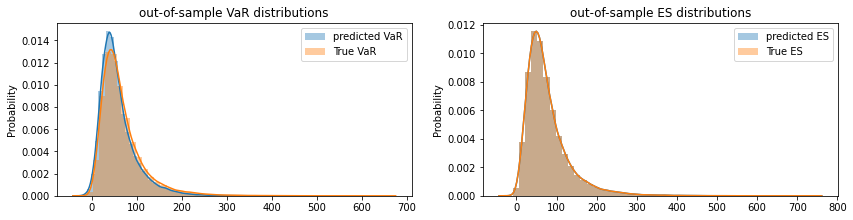

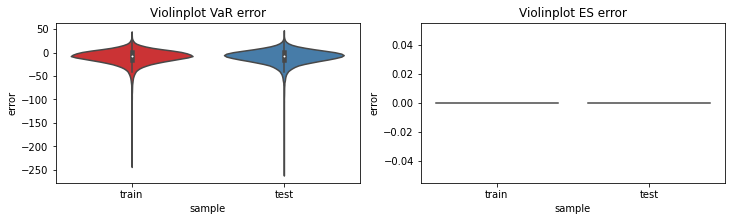

In [ ]:
plot_function(var_NN(X_train), true_VaR_train,
              true_ES_train, true_ES_train,
              var_NN(X_test), true_VaR_test,
              true_ES_test, true_ES_test)

### NN with Huber loss

In [ ]:
%%time
var_NN_Huber = NN_nlayers(Layers=[dim_X,400,1], activation =F.elu).to(device)

train_var_huberloss(var_NN_Huber, X_train_var= X_train, y_train= Y_train, eps = eps,
                    learning_rate = 0.1, epochs = 300, stop_eps = 1e-8, verbose = 100)

===Train VaR process===
[iter 0] err = 22.288
[iter 100] err = 1.453
[iter 104] err = nan
Best error = 1.379827618598938
CPU times: user 364 ms, sys: 136 ms, total: 500 ms
Wall time: 505 ms


NRMSE in-sample VaR:  0.3261527419090271
NRMSE out-sample VaR:  0.33216392993927
NRMSE in-sample ES:  0.0
NRMSE out-sample ES:  0.0
RMSE in-sample VaR:  15.695414543151855
RMSE out-sample VaR:  16.04946517944336
Quantile loss in-sample:  1.4841195344924927
Quantile loss out-sample:  1.809757947921753
Quantile proba in-sample:  0.05392
Quantile proba out-sample:  0.062


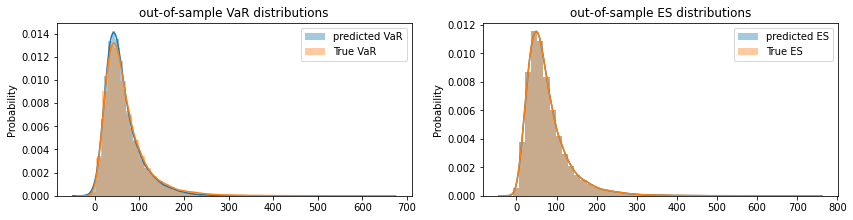

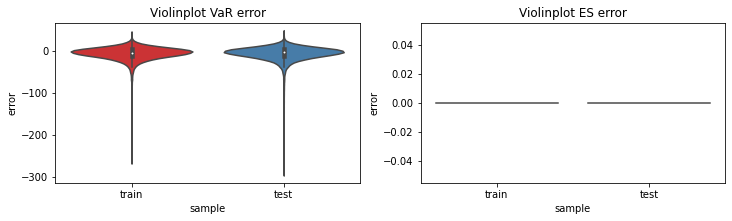

In [ ]:
plot_function(var_NN_Huber(X_train), true_VaR_train,
              true_ES_train, true_ES_train,
              var_NN_Huber(X_test), true_VaR_test,
              true_ES_test, true_ES_test)

### ELM using Adam optimizer

In [ ]:
%%time
K = 1200
RP_layer = Randomprojection(Layers=[dim_X,K], random_state= None, activation= F.elu, 
                            projection = 'Gauss')
# ['Gauss', 'Rademacher', 'Achlioptas', Gauss_normalized]
X_train_transfomed = RP_layer.fit_transform(X_train)
X_test_transfomed = RP_layer.fit_transform(X_test)
       
var_NN = NN_nlayers(Layers=[K,1], activation = torch.nn.Identity).to(device)

train_var_RUbased_fullbatch(var_NN, X_train_transfomed, Y_train,eps = eps,
                            learning_rate = 0.1, epochs = 500, stop_eps = 1e-8, verbose = 100)

===Train VaR process===
[iter 0] err = 842.246
[iter 100] err = 118.799
[iter 200] err = 100.343
[iter 300] err = 94.04
[iter 400] err = 91.034
[iter 500] err = 90.123
Best error = 89.41067504882812
CPU times: user 690 ms, sys: 126 ms, total: 816 ms
Wall time: 827 ms


NRMSE in-sample VaR:  0.5478659868240356
NRMSE out-sample VaR:  0.5513014793395996
NRMSE in-sample ES:  0.0
NRMSE out-sample ES:  0.0
RMSE in-sample VaR:  26.364896774291992
RMSE out-sample VaR:  26.637731552124023
Quantile loss in-sample:  1.7926362752914429
Quantile loss out-sample:  2.0162110328674316
Quantile proba in-sample:  0.03784
Quantile proba out-sample:  0.0402


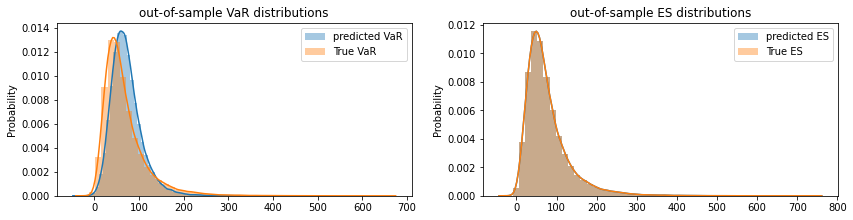

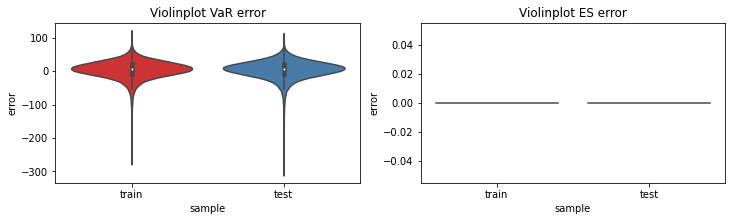

In [ ]:
plot_function(var_NN(X_train_transfomed), true_VaR_train,
              true_ES_train, true_ES_train,
              var_NN(X_test_transfomed), true_VaR_test,
              true_ES_test, true_ES_test)

### ELM using IRLS

In [ ]:

%%time
K = 1200
RP_layer = Randomprojection(Layers=[dim_X,K], random_state= None, activation= F.elu,
                            projection='Gauss'
                            )
# ['Gauss', 'Rademacher', 'Achlioptas']
X_train_transfomed = RP_layer.fit_transform(X_train)
X_test_transfomed = RP_layer.fit_transform(X_test)
LR_quantile = IRLS_quantile_regression(regularization_weight=0.)

LR_quantile.fit(X_train_transfomed,Y_train)



CPU times: user 1.06 s, sys: 529 ms, total: 1.59 s
Wall time: 1.59 s


NRMSE in-sample VaR:  0.5574595928192139
NRMSE out-sample VaR:  0.5630464553833008
NRMSE in-sample ES:  0.0
NRMSE out-sample ES:  0.0
RMSE in-sample VaR:  26.826568603515625
RMSE out-sample VaR:  27.205224990844727
Quantile loss in-sample:  2.006195545196533
Quantile loss out-sample:  2.3402371406555176
Quantile proba in-sample:  0.0695
Quantile proba out-sample:  0.07894


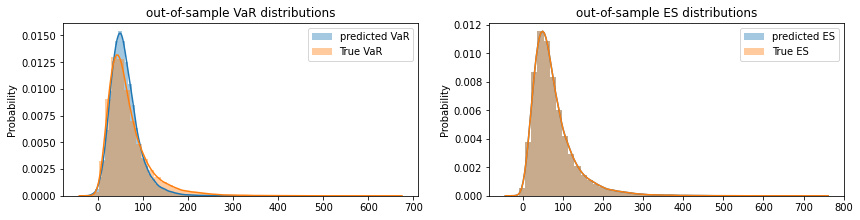

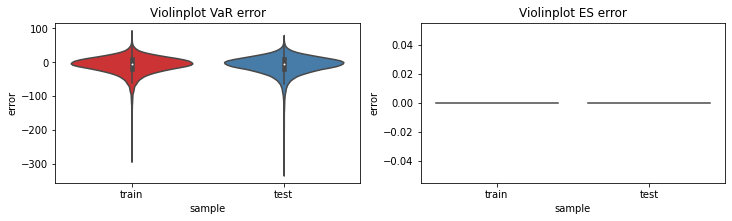

In [ ]:
plot_function(LR_quantile.predict(X_train_transfomed), true_VaR_train,
              true_ES_train, true_ES_train,
              LR_quantile.predict(X_test_transfomed), true_VaR_test,
              true_ES_test, true_ES_test)        

### RBF using IRLS

In [ ]:
%%time
RBF_hlayer = RBFlayer(output_layer = 200, e = 0.1, 
                      function ='Thin plate spline'
                      )

RBF_hlayer.fit(X_train)

X_train_transfomed = RBF_hlayer.transform(X_train).to(device)
X_test_transfomed = RBF_hlayer.transform(X_test).to(device)
LR_quantile = IRLS_quantile_regression(regularization_weight=0.)

LR_quantile.fit(X_train_transfomed,Y_train)


CPU times: user 567 ms, sys: 110 ms, total: 677 ms
Wall time: 678 ms


NRMSE in-sample VaR:  1.4325032234191895
NRMSE out-sample VaR:  1.4263005256652832
NRMSE in-sample ES:  0.0
NRMSE out-sample ES:  0.0
RMSE in-sample VaR:  68.93620300292969
RMSE out-sample VaR:  68.91585540771484
Quantile loss in-sample:  13.894278526306152
Quantile loss out-sample:  13.781776428222656
Quantile proba in-sample:  0.44468
Quantile proba out-sample:  0.4449


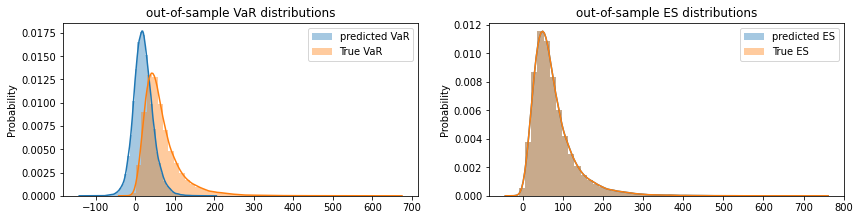

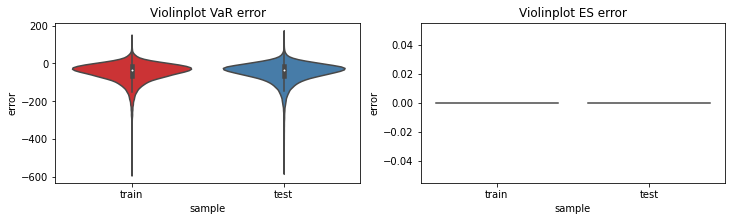

In [ ]:
plot_function(LR_quantile.predict(X_train_transfomed), true_VaR_train,
              true_ES_train, true_ES_train,
              LR_quantile.predict(X_test_transfomed), true_VaR_test,
              true_ES_test, true_ES_test)  

##5.2 Expected Shortfall

To train ES by two-step approach, we take VaR predicted by NN training Huber loss as reference.

In [ ]:
Y_train_es = 1/eps*torch.relu(Y_train - var_NN_Huber(X_train).data) + var_NN_Huber(X_train).data

We define training function for ES. This function is similar to the function training quadratic loos in Pricing problem

In [ ]:
def train_l2(model, x_train, y_train, learning_rate, regularization_weight,
                    epochs=max_epochs, stop_eps = 1e-8, verbose = None) :
    """
    Train quadratic loss function with full batchsize

    This function trains Pytorch neural network module by Adam optimizer with 
    full batch size. 
    
    Parameters
    ----------
    model : torch.nn.Module
        Neural network model
    X_train : torch.Tensor
        Training input
    y_train : torch.Tensor
        Training output
    learning_rate : float, default = 0.1
        Learning rate of Adam optimizer
    regularization_weight : float, default = 0
        Regularization weight. Larger values specify stronger regularization.
    epochs : int,  default = Model parameters
        Number of iterations doing parameters update.
    stop_eps : int default = 1e-8
        Early stopping criterion.
    verbose : int, default = None
        The verbosity level of training loss function. If None, nothing is printed.
    Returns
    -------
    model is trained. 
    """

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization_weight)
    i = 0
    err, best_err = np.inf, np.inf
    while (abs(err) > 1e-8) and (i < epochs):
        optimizer.zero_grad()
        pred = model(x_train)
        loss = F.mse_loss(pred, y_train)
        if err < best_err:
            best_err = err
            torch.save(model.state_dict(), 'best') 
        loss.backward()
        optimizer.step()
        err = loss.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))

    model.load_state_dict(torch.load('best'))
    model.eval()    

### NN

In [ ]:
%%time
es_NN =NN_nlayers(Layers=[dim_X,400,1], activation =F.elu).to(device)

train_l2(es_NN, X_train, Y_train_es, learning_rate=0.01, regularization_weight=0.5,
         epochs = 300, verbose = 100)

[iter 0] err = 22694.65
[iter 100] err = 14205.742
[iter 200] err = 13829.991
[iter 300] err = 13492.508
Best error = 13495.8447265625
CPU times: user 1.04 s, sys: 400 ms, total: 1.44 s
Wall time: 1.45 s


NRMSE in-sample VaR:  0.0
NRMSE out-sample VaR:  0.0
NRMSE in-sample ES:  0.3550012707710266
NRMSE out-sample ES:  0.35774925351142883
RMSE in-sample VaR:  0.0
RMSE out-sample VaR:  0.0
Quantile loss in-sample:  1.4519572257995605
Quantile loss out-sample:  1.4340579509735107
Quantile proba in-sample:  0.02482
Quantile proba out-sample:  0.02482


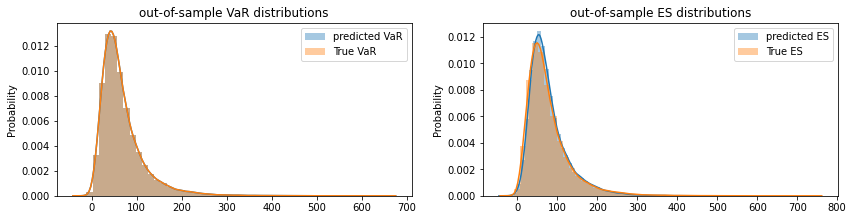

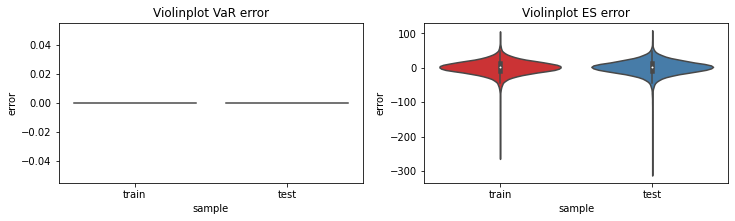

In [ ]:
plot_function(true_VaR_train, true_VaR_train,
              es_NN(X_train), true_ES_train,
              true_VaR_test, true_VaR_test,
              es_NN(X_test), true_ES_test)

### ELM

In [ ]:
%%time
K= 3000
LR_solution = LR_readout_cuml(regularization_weight= 0.1)

RP_layer = Randomprojection(Layers=[dim_X,K], random_state= None, activation= F.elu,
                            projection='Gauss'
                            )
# ['Gauss', 'Rademacher', 'Achlioptas']
X_train_transfomed = RP_layer.fit_transform(X_train)
X_test_transfomed = RP_layer.fit_transform(X_test)

LR_solution.fit(X_train_transfomed, Y_train_es)

CPU times: user 402 ms, sys: 204 ms, total: 606 ms
Wall time: 609 ms


NRMSE in-sample VaR:  0.0
NRMSE out-sample VaR:  0.0
NRMSE in-sample ES:  0.6330001950263977
NRMSE out-sample ES:  0.6507930755615234
RMSE in-sample VaR:  0.0
RMSE out-sample VaR:  0.0
Quantile loss in-sample:  1.4519572257995605
Quantile loss out-sample:  1.4340579509735107
Quantile proba in-sample:  0.02482
Quantile proba out-sample:  0.02482


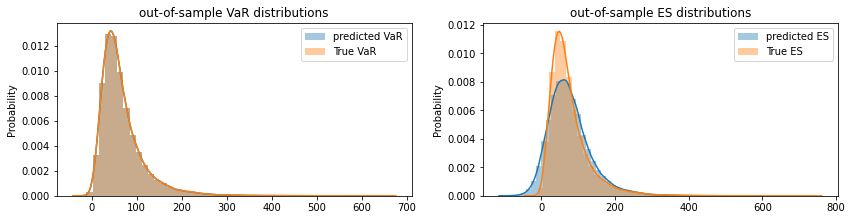

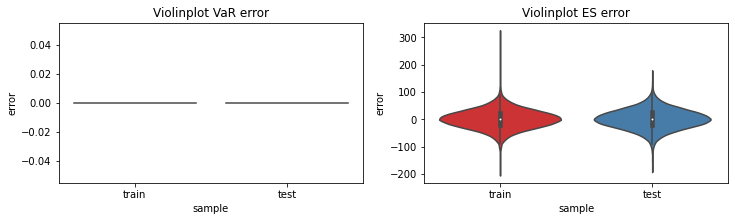

In [ ]:
plot_function(true_VaR_train, true_VaR_train,
              LR_solution.predict(X_train_transfomed).view(-1,1), true_ES_train,
              true_VaR_test, true_VaR_test,
              LR_solution.predict(X_test_transfomed).view(-1,1), true_ES_test)

### RBF

In [ ]:
%%time
K = 800
RBF_hlayer = RBFlayer(output_layer = K, e = 10, 
                      function ='Thin plate spline'
                      )

RBF_hlayer.fit(X_train)

LR_solution = LR_readout_cuml(regularization_weight= 0.5)

X_train_transfomed = RBF_hlayer.transform(X_train).to(device)
X_test_transfomed = RBF_hlayer.transform(X_test).to(device)
LR_solution.fit(X_train_transfomed, Y_train_es)

CPU times: user 1.93 s, sys: 414 ms, total: 2.34 s
Wall time: 2.34 s


NRMSE in-sample VaR:  0.0
NRMSE out-sample VaR:  0.0
NRMSE in-sample ES:  0.5104517936706543
NRMSE out-sample ES:  0.5215040445327759
RMSE in-sample VaR:  0.0
RMSE out-sample VaR:  0.0
Quantile loss in-sample:  1.4519572257995605
Quantile loss out-sample:  1.4340579509735107
Quantile proba in-sample:  0.02482
Quantile proba out-sample:  0.02482


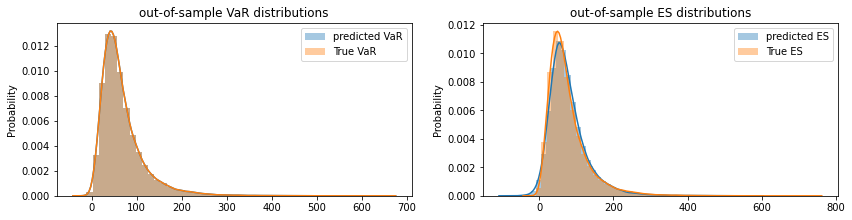

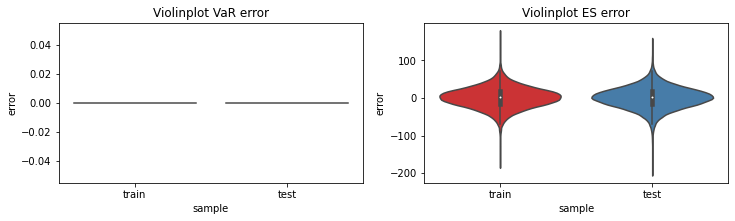

In [ ]:
plot_function(true_VaR_train, true_VaR_train,
              LR_solution.predict(X_train_transfomed).view(-1,1), true_ES_train,
              true_VaR_test, true_VaR_test,
              LR_solution.predict(X_test_transfomed).view(-1,1), true_ES_test)

#6 FZ joint approach

We define g1, g2 and its derivative functions and then training function for joint approach.

In [ ]:
a = Y_train.std()
g1 = lambda x: x
g2 = lambda x: -torch.log(1 + torch.exp(-x/a))
g2dot = lambda x: torch.exp(-x/a)/(a + a*torch.exp(-x/a))

In [ ]:
def joint_train_var_es_model(model_var_es, x_train, y_train, eps = eps,
                             learning_rate = 0.1, regularization_weight = 0, 
                             g1_func = g1, g2_func = g2, g2_dot_func = g2dot,
                             epochs = 500, stop_eps = 1e-8, verbose = None) :
    """
    Train FZ joint loss

    This function trains FZ joint loss for the couple (VaR, ES) regression. 
    
    Parameters
    ----------
    model_var_es : torch.nn.Module
        Neural network model
    x_train : torch.Tensor
        Training input
    y_train : torch.Tensor
        Training output
    eps : float, default = Model paramters
        1 - eps is the involved confidence level. 0 < eps < 1.
    learning_rate : float, default = 0.1
        Learning rate of Adam optimizer
    regularization_weight : float, default = 0
        Regularization weight. Larger values specify stronger regularization.
    g1_func : function
        g1 function
    g2_func : function
        g2 function
    g2_dot_func : function
        Derivative of g2 function
    epochs : int,  default = Model parameters
        Number of iterations doing parameters update.
    stop_eps : int default = 1e-8
        Early stopping criterion.
    verbose : int, default = None
        The verbosity level of training loss function. If None, nothing is printed.
    Returns
    -------
    model is trained. 
    """                             
    optimizer = torch.optim.Adam(model_var_es.parameters(), lr=learning_rate,
                                 weight_decay=regularization_weight)
    i = 0
    best_err, err =  np.inf, np.inf

    while (abs(err) > stop_eps) and (i < epochs):       
        optimizer.zero_grad()
        pred = model_var_es(x_train)
        q = pred[:,0:1]
        e = pred[:,1:2]
        loss = torch.mean(1/eps*torch.relu(g1_func(y_train) - g1_func(q)) + g1_func(q) +
                          g2_func(e) - g2_dot_func(e)*(e - q - 1/eps*torch.relu(y_train - q)) )
                      
        loss.backward()
        optimizer.step()
        err = loss.data.item()
        if err < best_err:
            best_err = err
            torch.save(model_var_es.state_dict(), 'best')

        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))
    model_var_es.load_state_dict(torch.load('best'))
    model_var_es.eval()

In [ ]:
%%time
var_es_NN = NN_nlayers(Layers=[dim_X,200,2], activation=F.elu).to(device)

joint_train_var_es_model(var_es_NN, X_train, Y_train,
                         learning_rate = 0.1, regularization_weight = 0.,
                         epochs=500, verbose = 100)

[iter 0] err = 918.631
[iter 100] err = 74.558
[iter 200] err = 71.406
[iter 300] err = 75.985
[iter 400] err = 96.761
[iter 500] err = 86.718
Best error = 64.96163177490234
CPU times: user 1.41 s, sys: 156 ms, total: 1.57 s
Wall time: 1.61 s


NRMSE in-sample VaR:  0.36282506585121155
NRMSE out-sample VaR:  0.3656546473503113
NRMSE in-sample ES:  0.4286051392555237
NRMSE out-sample ES:  0.4310223460197449
RMSE in-sample VaR:  17.46019172668457
RMSE out-sample VaR:  17.667667388916016
Quantile loss in-sample:  1.2691423892974854
Quantile loss out-sample:  1.999386191368103
Quantile proba in-sample:  0.06388
Quantile proba out-sample:  0.08978


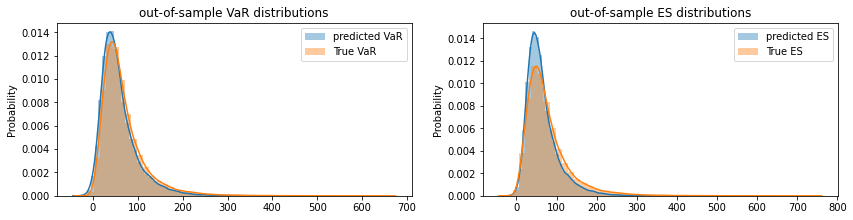

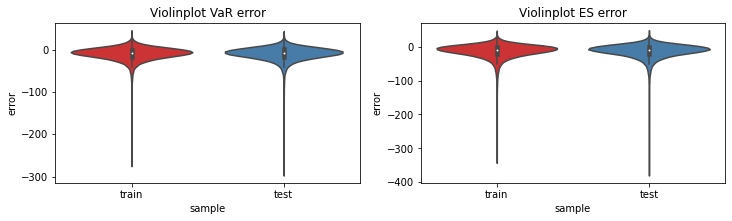

In [ ]:
plot_function(var_es_NN(X_train)[:,0:1], true_VaR_train,
              var_es_NN(X_train)[:,1:2], true_ES_train,
              var_es_NN(X_test)[:,0:1], true_VaR_test,
              var_es_NN(X_test)[:,1:2], true_ES_test)

Let's try to apply randomized networks to the joint approach.

In [ ]:
%%time
K = 1200
RP_layer = Randomprojection(Layers=[dim_X,K], random_state= None, activation= F.elu, 
                            projection = 'Gauss')
# ['Gauss', 'Rademacher', 'Achlioptas', Gauss_normalized]
X_train_transfomed = RP_layer.fit_transform(X_train)
X_test_transfomed = RP_layer.fit_transform(X_test)
       
var_es_NN = NN_nlayers(Layers=[K,2], activation=F.elu).to(device)

joint_train_var_es_model(var_es_NN, X_train_transfomed, Y_train,
                         learning_rate = 0.1, regularization_weight = 0.,
                         epochs=500, verbose = 100)

[iter 0] err = 922.884
[iter 100] err = 118.771
[iter 200] err = 99.042
[iter 300] err = 92.971
[iter 400] err = 90.264
[iter 500] err = 89.532
Best error = 88.86751556396484
CPU times: user 1.15 s, sys: 131 ms, total: 1.28 s
Wall time: 1.3 s


NRMSE in-sample VaR:  0.5349912047386169
NRMSE out-sample VaR:  0.5411785244941711
NRMSE in-sample ES:  26.372255325317383
NRMSE out-sample ES:  26.27112579345703
RMSE in-sample VaR:  25.745325088500977
RMSE out-sample VaR:  26.14861297607422
Quantile loss in-sample:  1.7734334468841553
Quantile loss out-sample:  1.98827064037323
Quantile proba in-sample:  0.03606
Quantile proba out-sample:  0.03862


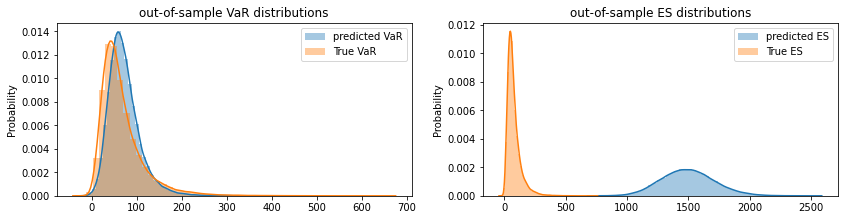

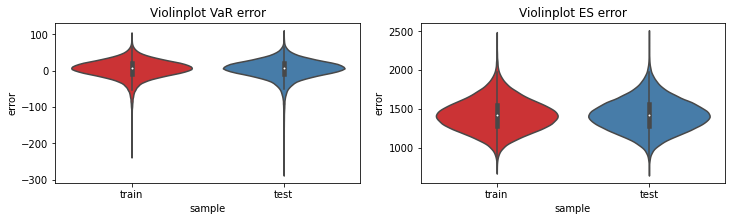

In [ ]:
plot_function(var_es_NN(X_train_transfomed)[:,0:1], true_VaR_train,
              var_es_NN(X_train_transfomed)[:,1:2], true_ES_train,
              var_es_NN(X_test_transfomed)[:,0:1], true_VaR_test,
              var_es_NN(X_test_transfomed)[:,1:2], true_ES_test)

The result is acceptable for VaR but is really bad for ES!!!

#7 Benchmark

## VaR

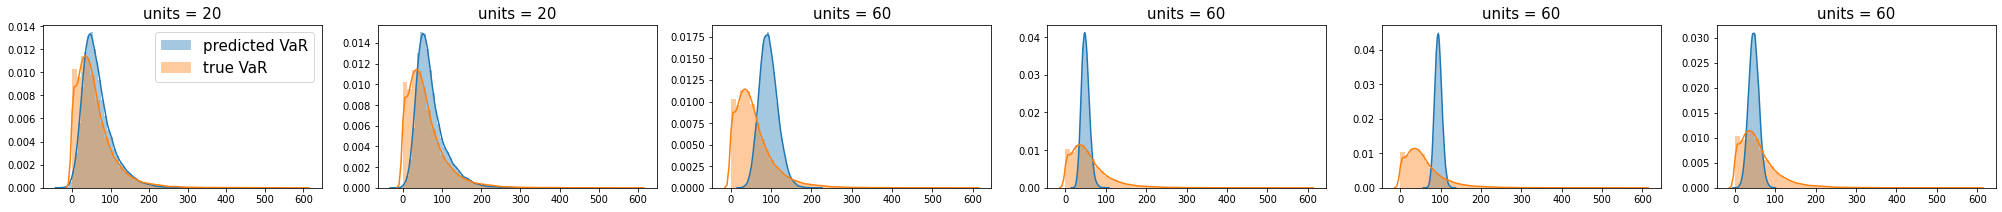

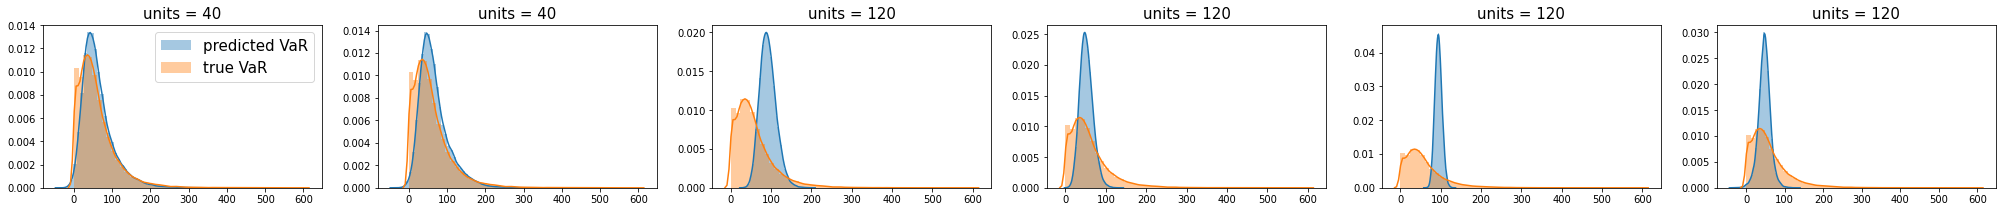

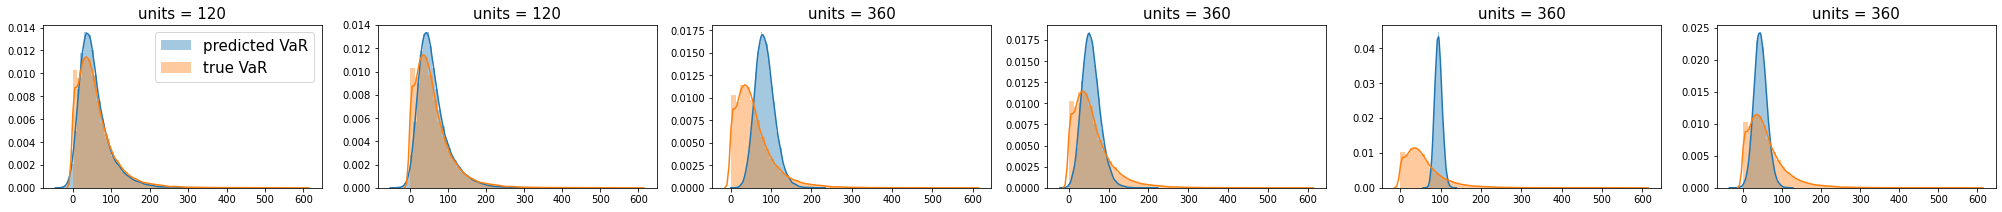

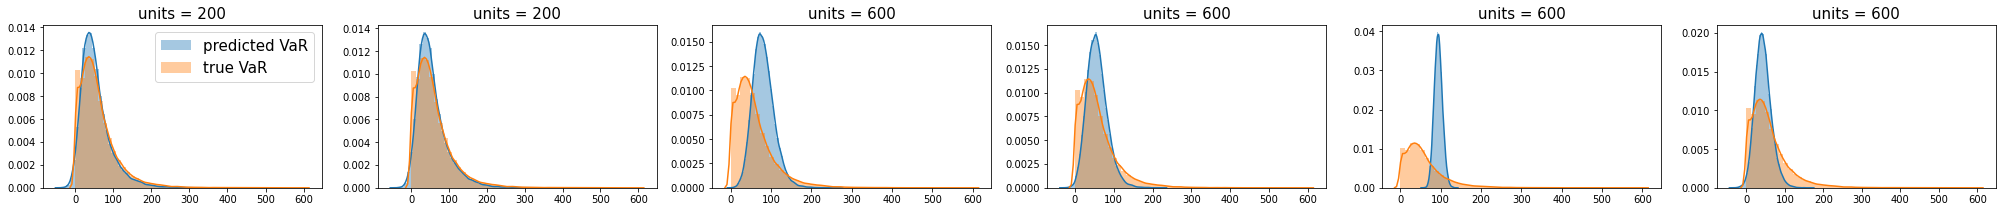

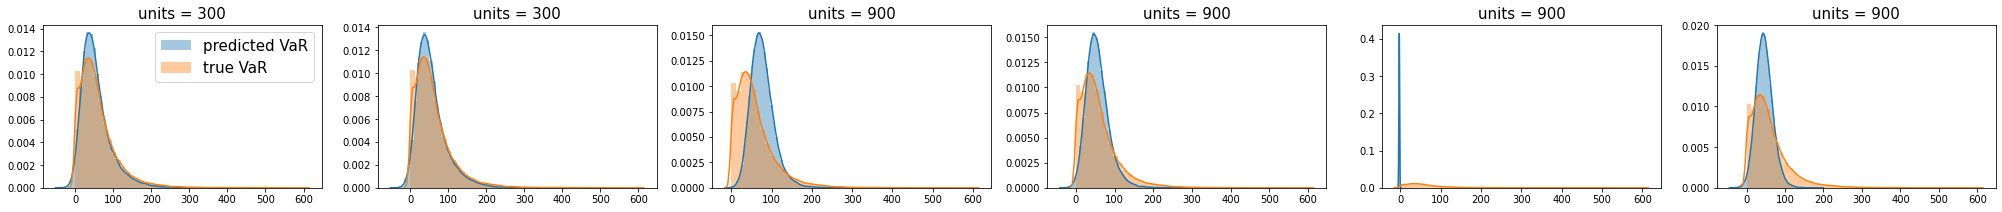

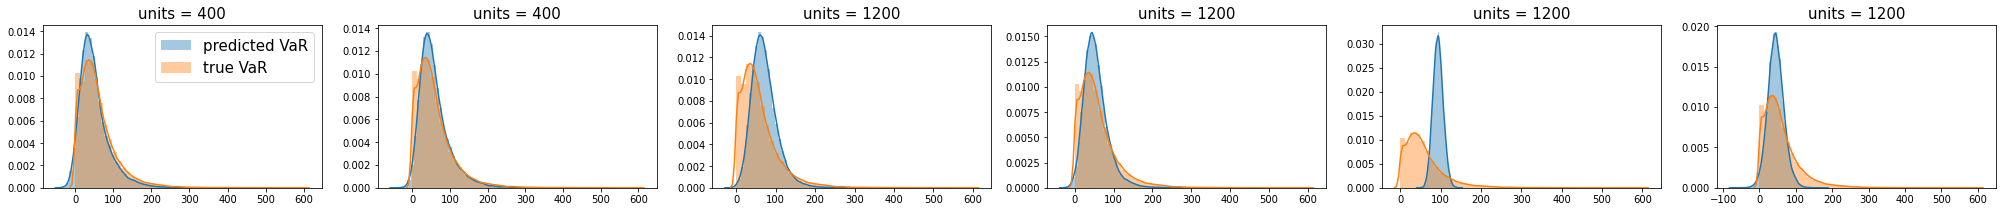

In [ ]:
hunits_list = [20,40,120,200,300,400]
NRMSE_Var_NN_list = []
RMSE_Var_NN_list = []
Qloss_NN_list = []
time_NN_list = []

NRMSE_Var_NN_Huber_list = []
RMSE_Var_NN_Huber_list = []
Qloss_NN_Huber_list = []
time_NN_Huber_list = []

NRMSE_Var_ELM_Adam_list = []
RMSE_Var_ELM_Adam_list = []
Qloss_ELM_Adam_list = []
time_ELM_Adam_list = []

NRMSE_Var_ELM_IR_list = []
RMSE_Var_ELM_IR_list = []
Qloss_ELM_IR_list = []
time_ELM_IR_list = []

NRMSE_Var_RBF_Adam_list = []
RMSE_Var_RBF_Adam_list = []
Qloss_RBF_Adam_list = []
time_RBF_Adam_list = []

NRMSE_Var_RBF_IR_list = []
RMSE_Var_RBF_IR_list = []
Qloss_RBF_IR_list = []
time_RBF_IR_list = []


for units in hunits_list:
    ###### standard NN #####
    p1 = time.time()
    var_NN = NN_nlayers(Layers=[dim_X,units,1], activation =F.elu).to(device)

    train_var_RUbased_fullbatch(var_NN, X_train_var= X_train, y_train= Y_train, eps = eps,
                                learning_rate = 0.1, epochs = 300, stop_eps = 1e-8, verbose = 100)
    time_NN_list.append(time.time() - p1)

    NRMSE_Var_NN_list.append(NRMSE(var_NN(X_test), true_VaR_test))
    RMSE_Var_NN_list.append(RMSE(var_NN(X_test), true_VaR_test))
    Qloss_NN_list.append(qloss(var_NN(X_test), Y_test))
    var_NN_predicted = var_NN(X_test).cpu().data
    
    ###### NN Huber loss #####
    p1 = time.time()
    var_NN = NN_nlayers(Layers=[dim_X,units,1], activation =F.elu).to(device)

    train_var_huberloss(var_NN, X_train_var= X_train, y_train= Y_train, eps = eps,
                        learning_rate = 0.1, epochs = 300, stop_eps = 1e-8, verbose = 100)
    time_NN_Huber_list.append(time.time() - p1)

    NRMSE_Var_NN_Huber_list.append(NRMSE(var_NN(X_test), true_VaR_test))
    RMSE_Var_NN_Huber_list.append(RMSE(var_NN(X_test), true_VaR_test))
    Qloss_NN_Huber_list.append(qloss(var_NN(X_test), Y_test))
    var_NN_Huber_predicted = var_NN(X_test).cpu().data

    ###### ELM Adam #####
    p1 = time.time()
    RP_layer = Randomprojection(Layers=[dim_X,units*3], random_state= None, activation= F.elu, 
                            projection = 'Gauss')

    X_train_transfomed = RP_layer.fit_transform(X_train)
    X_test_transfomed = RP_layer.fit_transform(X_test)
       
    var_NN = NN_nlayers(Layers=[units*3,1], activation =F.relu).to(device)

    train_var_RUbased_fullbatch(var_NN, X_train_var= X_train_transfomed,y_train= Y_train,eps = eps, 
                                learning_rate = 0.1, epochs = 300, stop_eps = 1e-8, verbose = 100)
    time_ELM_Adam_list.append(time.time() - p1)

    NRMSE_Var_ELM_Adam_list.append(NRMSE(var_NN(X_test_transfomed), true_VaR_test))
    RMSE_Var_ELM_Adam_list.append(RMSE(var_NN(X_test_transfomed), true_VaR_test))
    Qloss_ELM_Adam_list.append(qloss(var_NN(X_test_transfomed), Y_test))
    var_ELM_Adam_predicted = var_NN(X_test_transfomed).cpu().data

    ###### ELM IRLS #####
    p1 = time.time()
    RP_layer = Randomprojection(Layers=[dim_X,units*3], random_state= None, activation= F.elu,
                                projection='Achlioptas'
                                )

    X_train_transfomed = RP_layer.fit_transform(X_train)
    X_test_transfomed = RP_layer.fit_transform(X_test)
    LR_quantile = IRLS_quantile_regression(regularization_weight=0.)

    LR_quantile.fit(X_train_transfomed,Y_train)
    
    time_ELM_IR_list.append(time.time() - p1)

    NRMSE_Var_ELM_IR_list.append(NRMSE(LR_quantile.predict(X_test_transfomed), true_VaR_test))
    RMSE_Var_ELM_IR_list.append(RMSE(LR_quantile.predict(X_test_transfomed), true_VaR_test))
    Qloss_ELM_IR_list.append(qloss(LR_quantile.predict(X_test_transfomed), Y_test))
    var_ELM_IR_predicted = LR_quantile.predict(X_test_transfomed).cpu().data

    ###### RBF Adam #####
    p1 = time.time()

    RBF_hlayer = RBFlayer(output_layer = units*3, e = 1, 
                          function ='Multiquadric'
                          )
    RBF_hlayer.fit(X_train)

    X_train_transfomed = RBF_hlayer.transform(X_train).to(device)
    X_test_transfomed = RBF_hlayer.transform(X_test).to(device)

    var_NN = NN_nlayers(Layers=[units*3,1], activation = torch.nn.Identity).to(device)

    train_var_RUbased_fullbatch(var_NN, X_train_var= X_train_transfomed,y_train= Y_train,
                                learning_rate = 0.1, epochs = 300, stop_eps = 1e-8, verbose = 100)
    
    time_RBF_Adam_list.append(time.time() - p1)

    NRMSE_Var_RBF_Adam_list.append(NRMSE(var_NN(X_test_transfomed), true_VaR_test))
    RMSE_Var_RBF_Adam_list.append(RMSE(var_NN(X_test_transfomed), true_VaR_test))
    Qloss_RBF_Adam_list.append(qloss(var_NN(X_test_transfomed), Y_test))
    var_RBF_Adam_predicted = var_NN(X_test_transfomed).cpu().data

    ###### RBF IRLS #####
    p1 = time.time()

    RBF_hlayer = RBFlayer(output_layer = units*3, e = 1, 
                          function ='Multiquadric'
                          )
    RBF_hlayer.fit(X_train)

    X_train_transfomed = RBF_hlayer.transform(X_train).to(device)
    X_test_transfomed = RBF_hlayer.transform(X_test).to(device)

    LR_quantile = IRLS_quantile_regression(regularization_weight=1.)

    LR_quantile.fit(X_train_transfomed,Y_train)
    
    time_RBF_IR_list.append(time.time() - p1)

    NRMSE_Var_RBF_IR_list.append(NRMSE(LR_quantile.predict(X_test_transfomed), true_VaR_test))
    RMSE_Var_RBF_IR_list.append(RMSE(LR_quantile.predict(X_test_transfomed), true_VaR_test))
    Qloss_RBF_IR_list.append(qloss(LR_quantile.predict(X_test_transfomed), Y_test))
    var_RBF_IR_predicted = LR_quantile.predict(X_test_transfomed).cpu().data

    plt.figure(figsize=(35,3))
    plt.subplot(161)
    g = sns.distplot(var_NN_predicted, label='predicted VaR')
    g = sns.distplot(true_VaR_test.cpu().data, label='true VaR')
    g = plt.title("units = "+str(units), fontsize=15)
    g = plt.xlabel("")
    g = plt.legend(fontsize = 15)
    plt.subplot(162)
    g = sns.distplot(var_NN_Huber_predicted)
    g = sns.distplot(true_VaR_test.cpu().data)
    g = plt.title("units = "+str(units), fontsize=15)
    g = plt.xlabel("")
    plt.subplot(163)
    g = sns.distplot(var_ELM_Adam_predicted)
    g = sns.distplot(true_VaR_test.cpu().data)
    g = plt.title("units = "+str(units*3), fontsize=15)
    g = plt.xlabel("")
    #g = plt.legend(fontsize = 15)
    plt.subplot(164)
    g = sns.distplot(var_ELM_IR_predicted)
    g = sns.distplot(true_VaR_test.cpu().data)
    g = plt.title("units = "+str(units*3), fontsize=15)
    g = plt.xlabel("")
    #g = plt.legend(fontsize = 15)
    plt.subplot(165)
    g = sns.distplot(var_RBF_Adam_predicted)
    g = sns.distplot(true_VaR_test.cpu().data)
    g = plt.title("units = "+str(units*3), fontsize=15)
    g = plt.xlabel("")
    #g = plt.legend(fontsize = 15)
    plt.subplot(166)
    g = sns.distplot(var_RBF_IR_predicted)
    g = sns.distplot(true_VaR_test.cpu().data)
    g = plt.title("units = "+str(units*3), fontsize=15)
    g = plt.xlabel("")
    #g = plt.legend(fontsize = 15)
    plt.show()
    print('========================')
    del var_NN, LR_quantile, X_train_transfomed, X_test_transfomed, RBF_hlayer, RP_layer
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
result = pd.DataFrame()
result['Model'] = [i for i in ['NN', 'NN_Huber','ELM_Adam(x3)', 'ELM_IRLS(x3)', 'RBF_Adam(x3)', 'RBF_IRLS(x3)'] for _ in range(6)]
result['units'] = [20,40,120,200,300,400]*6
result['NRMSE'] = NRMSE_Var_NN_list + NRMSE_Var_NN_Huber_list+ NRMSE_Var_ELM_Adam_list + NRMSE_Var_ELM_IR_list + NRMSE_Var_RBF_Adam_list + NRMSE_Var_RBF_IR_list
result['RMSE'] = RMSE_Var_NN_list + RMSE_Var_NN_Huber_list + RMSE_Var_ELM_Adam_list + RMSE_Var_ELM_IR_list + RMSE_Var_RBF_Adam_list + RMSE_Var_RBF_IR_list
result['Qloss'] = Qloss_NN_list + Qloss_NN_Huber_list + Qloss_ELM_Adam_list + Qloss_ELM_IR_list + Qloss_RBF_Adam_list + Qloss_RBF_IR_list
result['time'] = time_NN_list + time_NN_Huber_list + time_ELM_Adam_list + time_ELM_IR_list + time_RBF_Adam_list + time_RBF_IR_list


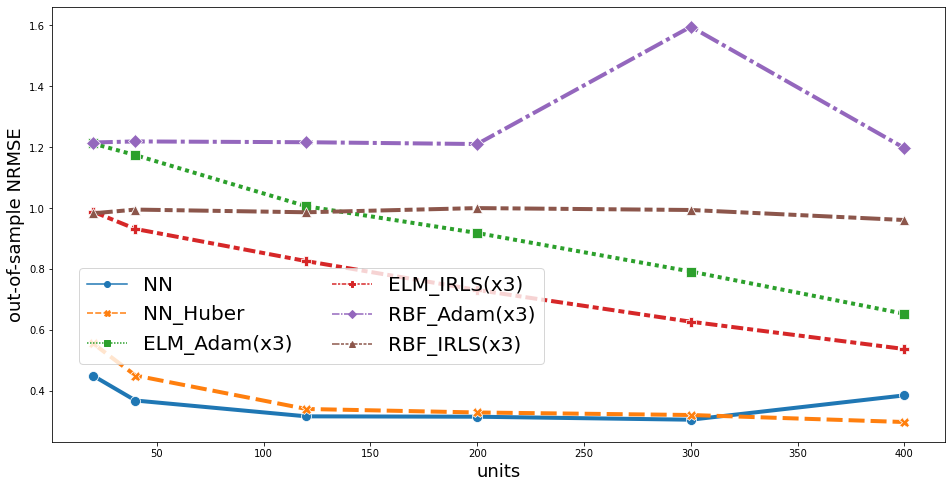

In [ ]:
plt.figure(figsize=(16,8))
g = sns.lineplot(data = result, x = 'units', y = 'NRMSE', style = 'Model', hue = 'Model',
                 linewidth = 4, markers=True, markersize = 10)
handles, labels = g.get_legend_handles_labels()
g = plt.ylabel("out-of-sample NRMSE", fontsize = 18)
g = plt.xlabel("units", fontsize = 18)

g = plt.legend(fontsize = 20, bbox_to_anchor=(0.03, 0.4), loc=2, borderaxespad=0.,
               ncol=2,handles=handles[1:], labels=labels[1:])

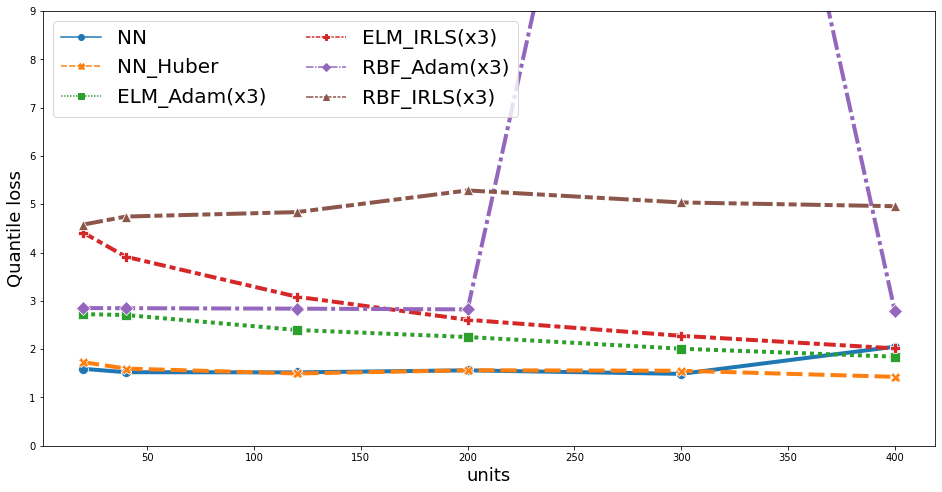

In [ ]:
plt.figure(figsize=(16,8))
g = sns.lineplot(data = result, x = 'units', y = 'Qloss', style = 'Model', hue = 'Model', 
                 linewidth = 4, markers=True, markersize = 10)
handles, labels = g.get_legend_handles_labels()
g = plt.ylabel("Quantile loss", fontsize = 18)
g = plt.xlabel("units", fontsize = 18)
plt.ylim([0,9])
g = plt.legend(fontsize = 20,loc='upper left', ncol=2,handles=handles[1:], labels=labels[1:])

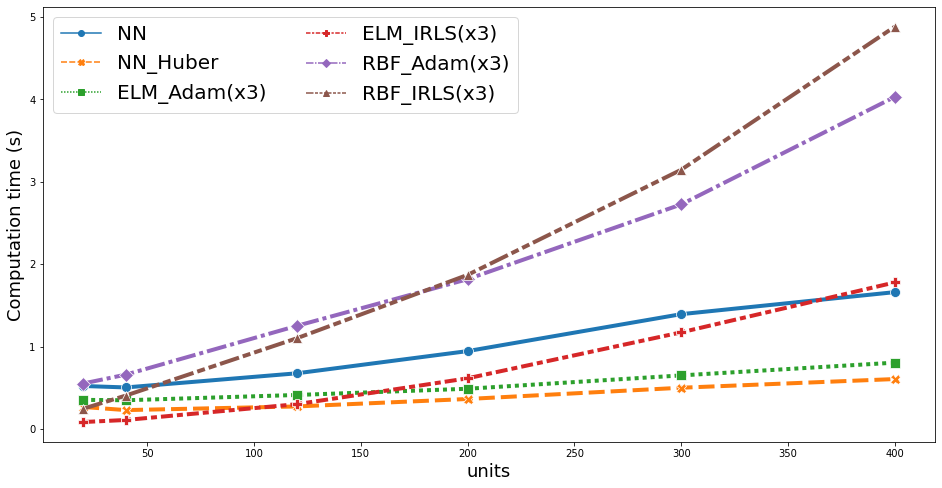

In [ ]:
plt.figure(figsize=(16,8))
g = sns.lineplot(data = result, x = 'units', y = 'time', style = 'Model', hue = 'Model', 
                 linewidth = 4, markers=True, markersize = 10)
handles, labels = g.get_legend_handles_labels()
g = plt.ylabel("Computation time (s)", fontsize = 18)
g = plt.xlabel("units", fontsize = 18)
g = plt.legend(fontsize = 20,loc = 'upper left', ncol=2,handles=handles[1:], labels=labels[1:])

In [ ]:
result

,Model,units,NRMSE,RMSE,Qloss,time
0,NN,20,0.450881,22.102074,1.593358,0.521096
1,NN,40,0.368879,18.082367,1.522880,0.503400
2,NN,120,0.316923,15.535478,1.519740,0.674899
3,NN,200,0.315702,15.475634,1.561408,0.944497
4,NN,300,0.305885,14.994426,1.488926,1.392946
5,NN,400,0.385780,18.910818,2.050456,1.660282
6,NN_Huber,20,0.556882,27.298220,1.731193,0.266293
7,NN_Huber,40,0.450937,22.104801,1.598227,0.228345
8,NN_Huber,120,0.341114,16.721302,1.496307,0.272572
9,NN_Huber,200,0.329627,16.158216,1.563581,0.363302


## ES

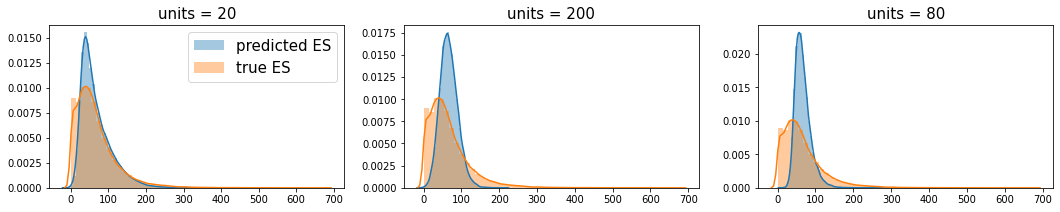

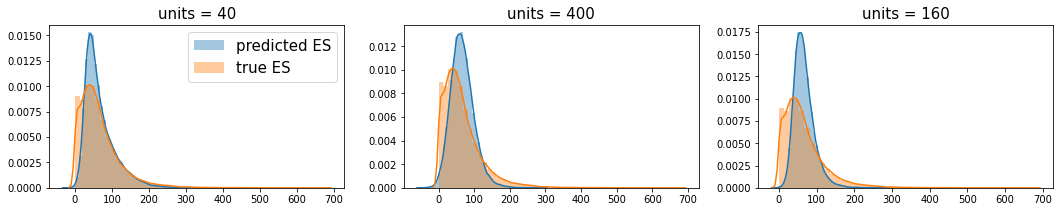

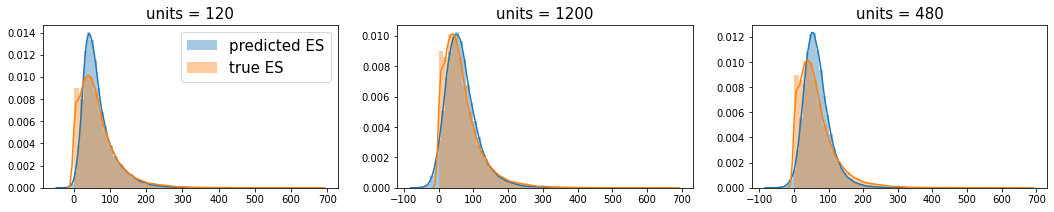

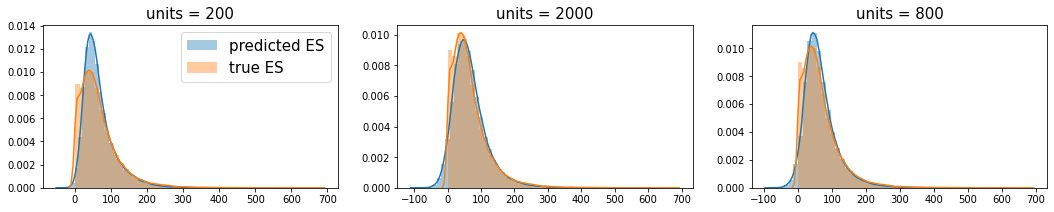

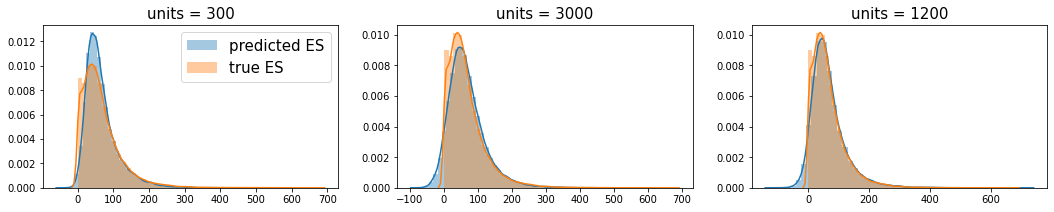

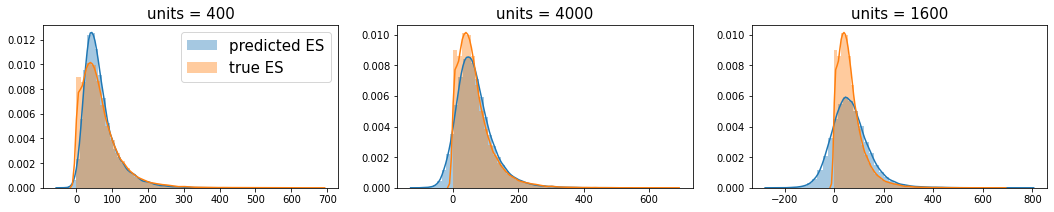

In [ ]:
hunits_list = [20,40,120,200,300,400]
NRMSE_ES_NN_list = []
RMSE_ES_NN_list = []
time_ES_NN_list = []

NRMSE_ES_ELM_list = []
RMSE_ES_ELM_list = []
time_ES_ELM_list = []

NRMSE_ES_RBF_list = []
RMSE_ES_RBF_list = []
time_ES_RBF_list = []

for units in hunits_list:

    p1 = time.time()
    es_NN =NN_nlayers(Layers=[dim_X,units,1], activation =F.elu).to(device)

    train_l2(es_NN, X_train, Y_train_es, learning_rate=0.01, regularization_weight=0.5,
             epochs = 300, verbose = None)
    time_ES_NN_list.append(time.time() - p1)

    NRMSE_ES_NN_list.append(NRMSE(es_NN(X_test), true_ES_test))
    RMSE_ES_NN_list.append(RMSE(es_NN(X_test), true_ES_test))
    es_NN_predicted = es_NN(X_test).cpu().data
    ####################
    p1 = time.time()
    
    LR_solution = LR_readout_cuml(regularization_weight= 0.1)

    RP_layer = Randomprojection(Layers=[dim_X,units*10], random_state= None, activation= F.elu,
                            projection='Achlioptas'
                            )
    # ['Gauss', 'Rademacher', 'Achlioptas']
    X_train_transfomed = RP_layer.fit_transform(X_train)
    X_test_transfomed = RP_layer.fit_transform(X_test)

    LR_solution.fit(X_train_transfomed, Y_train_es)
    time_ES_ELM_list.append(time.time() - p1)
    NRMSE_ES_ELM_list.append(NRMSE(LR_solution.predict(X_test_transfomed), true_ES_test))
    RMSE_ES_ELM_list.append(RMSE(LR_solution.predict(X_test_transfomed), true_ES_test))
    es_ELM_predicted = LR_solution.predict(X_test_transfomed).cpu().data

    ####################
    p1 = time.time()
    RBF_hlayer = RBFlayer(output_layer = units*4, e = 10, function ='Thin plate spline')
    RBF_hlayer.fit(X_train)

    LR_solution = LR_readout_cuml(regularization_weight= 0.5)

    X_train_transfomed = RBF_hlayer.transform(X_train).to(device)
    X_test_transfomed = RBF_hlayer.transform(X_test).to(device)
    LR_solution.fit(X_train_transfomed, Y_train_es)
    time_ES_RBF_list.append(time.time() - p1)
    NRMSE_ES_RBF_list.append(NRMSE(LR_solution.predict(X_test_transfomed), true_ES_test))
    RMSE_ES_RBF_list.append(RMSE(LR_solution.predict(X_test_transfomed), true_ES_test))
    es_RBF_predicted = LR_solution.predict(X_test_transfomed).cpu().data

    plt.figure(figsize=(18,3))
    plt.subplot(131)
    g = sns.distplot(es_NN_predicted, label='predicted ES')
    g = sns.distplot(true_ES_test.cpu().data, label='true ES')
    g = plt.title("units = "+str(units), fontsize=15)
    g = plt.xlabel("")
    g = plt.legend(fontsize = 15)
    plt.subplot(132)
    g = sns.distplot(es_ELM_predicted)
    g = sns.distplot(true_ES_test.cpu().data)
    g = plt.title("units = "+str(units*10), fontsize=15)
    g = plt.xlabel("")
    plt.subplot(133)
    g = sns.distplot(es_RBF_predicted)
    g = sns.distplot(true_ES_test.cpu().data)
    g = plt.title("units = "+str(units*4), fontsize=15)
    g = plt.xlabel("")
    #g = plt.legend(fontsize = 15)
    
    plt.show()
    print('========================')
    del es_NN, LR_solution, X_train_transfomed, X_test_transfomed, RBF_hlayer, RP_layer
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
result_ES = pd.DataFrame()
result_ES['Model'] = [i for i in ['NN', 'ELM(x10)', 'RBF(x4)'] for _ in range(6)]
result_ES['units'] = [20,40,120,200,300,400]*3
result_ES['NRMSE'] = NRMSE_ES_NN_list + NRMSE_ES_ELM_list + NRMSE_ES_RBF_list
result_ES['RMSE'] = RMSE_ES_NN_list + RMSE_ES_ELM_list + RMSE_ES_RBF_list
result_ES['time'] = time_ES_NN_list + time_ES_ELM_list + time_ES_RBF_list


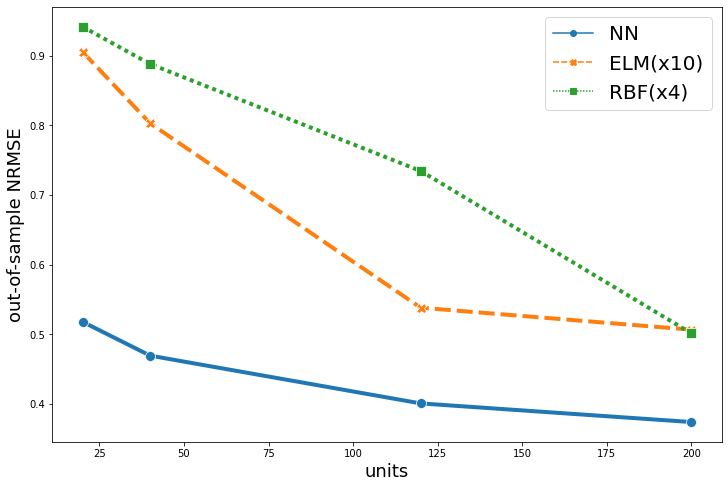

In [ ]:
plt.figure(figsize=(12,8))
g = sns.lineplot(data = result_ES[result_ES['units'].isin([20,40,120,200])], x = 'units', y = 'NRMSE', style = 'Model', hue = 'Model',
                 linewidth = 4, markers=True, markersize = 10)
handles, labels = g.get_legend_handles_labels()
g = plt.ylabel("out-of-sample NRMSE", fontsize = 18)
g = plt.xlabel("units", fontsize = 18)

g = plt.legend(fontsize = 20, ncol=1,handles=handles[1:], labels=labels[1:])


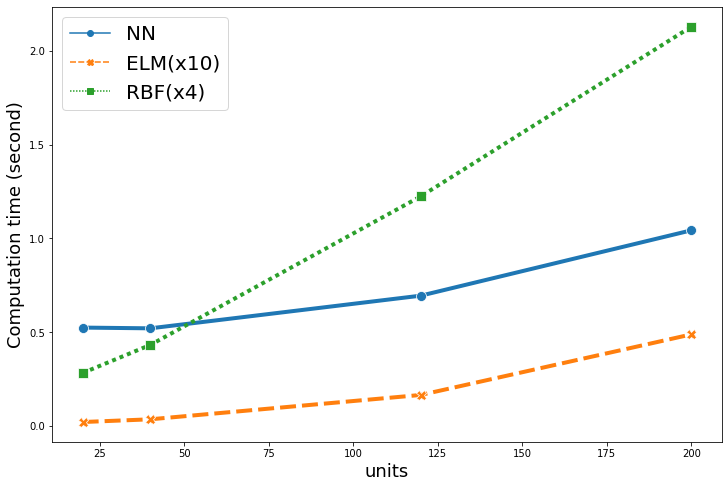

In [ ]:
plt.figure(figsize=(12,8))
g = sns.lineplot(data = result_ES[result_ES['units'].isin([20,40,120,200])], x = 'units', y = 'time', style = 'Model', hue = 'Model',
                 linewidth = 4, markers=True, markersize = 10)
handles, labels = g.get_legend_handles_labels()
g = plt.ylabel("Computation time (second)", fontsize = 18)
g = plt.xlabel("units", fontsize = 18)

g = plt.legend(fontsize = 20, ncol=1,handles=handles[1:], labels=labels[1:])


In [ ]:
result_ES

,Model,units,NRMSE,RMSE,time
0,NN,20,0.517986,28.604229,0.524855
1,NN,40,0.469373,25.919718,0.520918
2,NN,120,0.400766,22.131105,0.695169
3,NN,200,0.374026,20.654476,1.043651
4,NN,300,0.353260,19.507732,1.471813
5,NN,400,0.348247,19.230915,1.733835
6,ELM(x10),20,0.905666,50.012707,0.021171
7,ELM(x10),40,0.802984,44.342426,0.035715
8,ELM(x10),120,0.538180,29.719410,0.165631
9,ELM(x10),200,0.506657,27.978645,0.488587


In [ ]:
torch.cuda.empty_cache()
gc.collect()

34605

## Joint approach

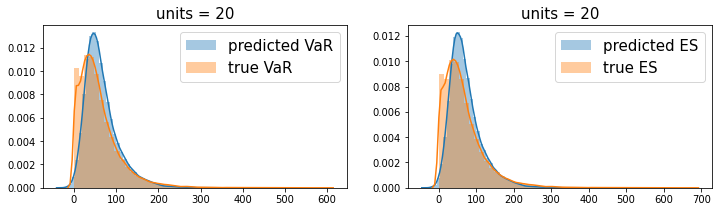

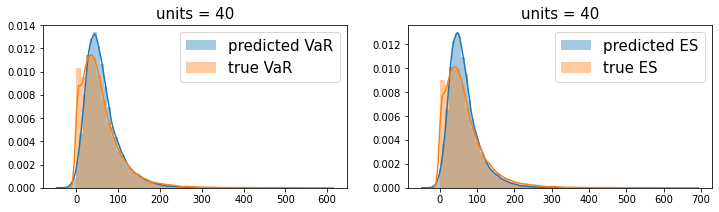

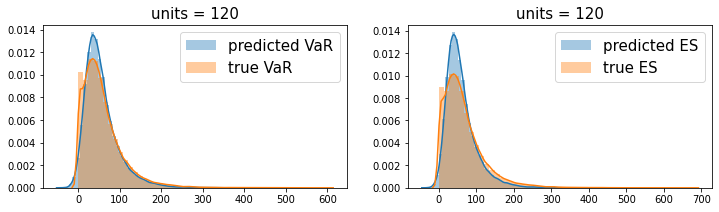

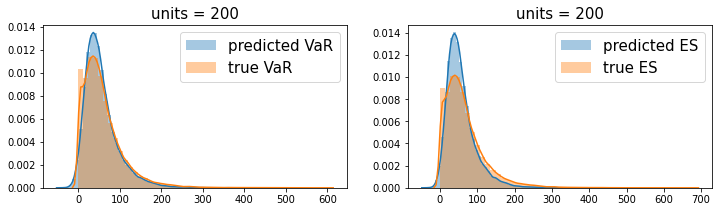

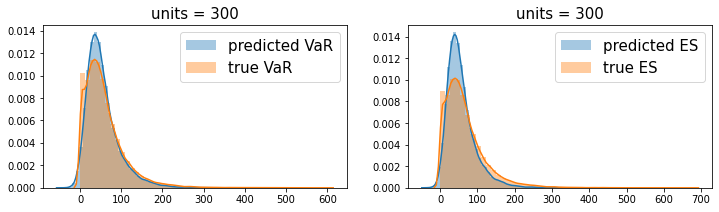

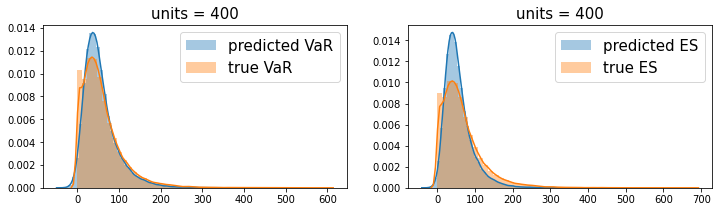

In [ ]:
hunits_list = [20,40,120,200,300,400]
#NRMSE_Var_RU_list = []
#RMSE_Var_RU_list = []
#NRMSE_ES_RU_list = []
#RMSE_ES_RU_list = []
#time_RU_list = []

NRMSE_Var_joint_list = []
RMSE_Var_joint_list = []
NRMSE_ES_joint_list = []
RMSE_ES_joint_list = []
time_joint_list = []

for units in hunits_list:
    p1 = time.time()
    var_es_NN = NN_nlayers(Layers=[dim_X,units,2], activation=F.elu).to(device)

    joint_train_var_es_model(var_es_NN, X_train, Y_train,
                             learning_rate = 0.1, regularization_weight = 0.,
                             epochs=300, verbose = None)
    time_joint_list.append(time.time() - p1)

    var_predicted = var_es_NN(X_test)[:,0:1]
    es_predicted = var_es_NN(X_test)[:,1:2]

    NRMSE_Var_joint_list.append(NRMSE(var_predicted, true_VaR_test))
    RMSE_Var_joint_list.append(RMSE(var_predicted, true_VaR_test))
    
    NRMSE_ES_joint_list.append(NRMSE(es_predicted, true_ES_test))
    RMSE_ES_joint_list.append(RMSE(es_predicted, true_ES_test))

    plt.figure(figsize=(12,3))
    plt.subplot(121)
    g = sns.distplot(var_predicted.cpu().data, label='predicted VaR')
    g = sns.distplot(true_VaR_test.cpu().data, label='true VaR')
    g = plt.title("units = "+str(units), fontsize=15)
    g = plt.xlabel("")
    g = plt.legend(fontsize = 15)
    plt.subplot(122)
    g = sns.distplot(es_predicted.cpu().data, label='predicted ES')
    g = sns.distplot(true_ES_test.cpu().data, label='true ES')
    g = plt.title("units = "+str(units), fontsize=15)
    g = plt.xlabel("")
    g = plt.legend(fontsize = 15)
    plt.show()
    print('========================')
    del var_es_NN
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
result_joint = pd.DataFrame()
result_joint['NRMSE_VaR'] = NRMSE_Var_joint_list
result_joint['RMSE_VaR'] = RMSE_Var_joint_list
result_joint['NRMSE_ES'] = NRMSE_ES_joint_list
result_joint['RMSE_ES'] = RMSE_ES_joint_list
result_joint['time'] = time_joint_list
result_joint['units'] = [20,40,120,200,300,400]

In [ ]:
result_joint

,NRMSE_VaR,RMSE_VaR,NRMSE_ES,RMSE_ES,time,units
0,0.429580,21.057920,0.431829,23.846487,0.851464,20
1,0.359798,17.637211,0.392685,21.684868,0.901204,40
2,0.319960,15.684357,0.389921,21.532206,0.904827,120
3,0.304509,14.926953,0.408185,22.540806,1.181367,200
4,0.303455,14.875262,0.418432,23.106659,1.615284,300
5,0.294298,14.426394,0.437392,24.153681,1.937948,400


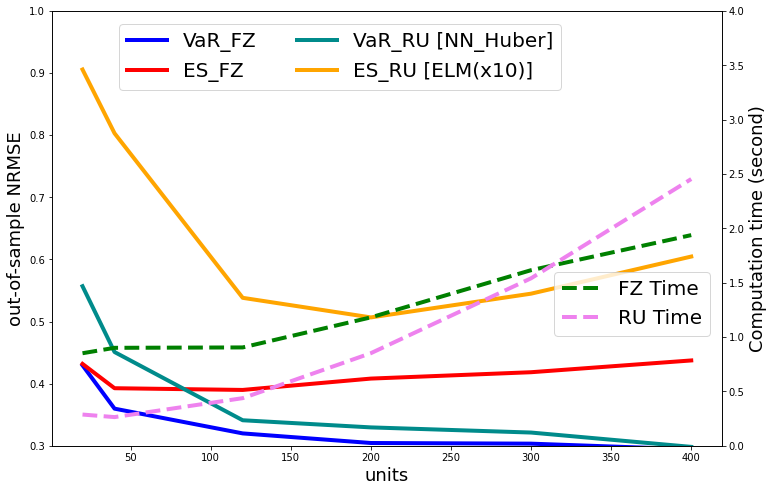

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(data=result_joint, x = 'units', y = 'NRMSE_VaR', linewidth = 4, label = 'VaR_FZ', color = 'b')
sns.lineplot(data=result_joint, x = 'units', y = 'NRMSE_ES', linewidth = 4, label = 'ES_FZ', color = 'red')
sns.lineplot(x = result['units'][result['Model'] == 'NN_Huber'], y = result['NRMSE'][result['Model'] == 'NN_Huber'], linewidth = 4, 
             label = 'VaR_RU [NN_Huber]', 
             color = 'darkcyan', linestyle='--')
sns.lineplot(x = result_ES['units'][result_ES['Model'] == 'ELM(x10)'], y = result_ES['NRMSE'][result_ES['Model'] == 'ELM(x10)'], linewidth = 4,
             label = 'ES_RU [ELM(x10)]',
             color = 'orange')

plt.ylabel("out-of-sample NRMSE", fontsize = 18)
plt.xlabel("units", fontsize = 18)
plt.ylim(0.3, 1)
plt.legend(fontsize = 20,bbox_to_anchor=(0.1, 0.97), loc=2, borderaxespad=0., ncol=2)
ax2 = plt.twinx()
g = sns.lineplot(data=result_joint, x = 'units', y = 'time', linewidth = 4, markers=True,ax=ax2, color = 'g', label = 'FZ Time', linestyle = '-')
g = sns.lineplot(x = result['units'][result['Model'] == 'NN_Huber'], 
                 y = result['time'][result['Model'] == 'NN_Huber'] + result_ES['time'][result_ES['Model'] == 'ELM(x10)'], 
                 linewidth = 4, markers=True,ax=ax2, color = 'violet', label = 'RU Time', linestyle = '-')
g.lines[0].set_linestyle("--")
g.lines[1].set_linestyle("--")
plt.ylabel("Computation time (second)", fontsize = 18)
plt.ylim(0, 4)
plt.legend(fontsize = 20,bbox_to_anchor=(0.75, 0.4), loc=2, borderaxespad=0., ncol=1)
plt.show()

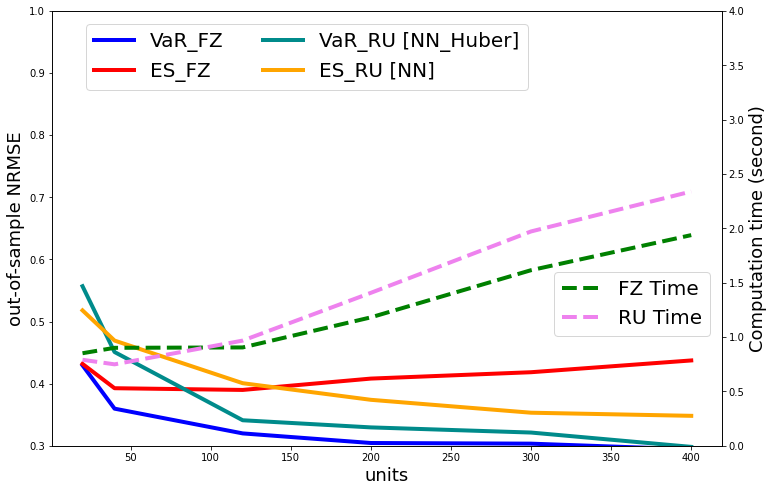

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(data=result_joint, x = 'units', y = 'NRMSE_VaR', linewidth = 4, label = 'VaR_FZ', color = 'b')
sns.lineplot(data=result_joint, x = 'units', y = 'NRMSE_ES', linewidth = 4, label = 'ES_FZ', color = 'red')
sns.lineplot(x = result['units'][result['Model'] == 'NN_Huber'], y = result['NRMSE'][result['Model'] == 'NN_Huber'], linewidth = 4, 
             label = 'VaR_RU [NN_Huber]', 
             color = 'darkcyan', linestyle='--')
sns.lineplot(x = result_ES['units'][result_ES['Model'] == 'NN'], y = result_ES['NRMSE'][result_ES['Model'] == 'NN'], linewidth = 4,
             label = 'ES_RU [NN]',
             color = 'orange')

plt.ylabel("out-of-sample NRMSE", fontsize = 18)
plt.ylim(0.3, 1)
plt.xlabel("units", fontsize = 18)
plt.legend(fontsize = 20,bbox_to_anchor=(0.05, 0.97), loc=2, borderaxespad=0., ncol=2)
ax2 = plt.twinx()
g = sns.lineplot(data=result_joint, x = 'units', y = 'time', linewidth = 4, markers=True,ax=ax2, color = 'g', label = 'FZ Time', linestyle = '-')
g = sns.lineplot(x = result['units'][result['Model'] == 'NN_Huber'].reset_index(drop=True), 
                 y = result['time'][result['Model'] == 'NN_Huber'].reset_index(drop=True) + result_ES['time'][result_ES['Model'] == 'NN'].reset_index(drop=True), 
                 linewidth = 4, markers=True,ax=ax2, color = 'violet', label = 'RU Time', linestyle = '-')
g.lines[0].set_linestyle("--")
g.lines[1].set_linestyle("--")
plt.ylabel("Computation time (second)", fontsize = 18)
plt.ylim(0, 4)
plt.legend(fontsize = 20,bbox_to_anchor=(0.75, 0.4), loc=2, borderaxespad=0., ncol=1)
plt.show()